# NE 204 Lab 1 Analysis
## Kalie Knecht
Lab Partners: Ian Kolaja, Trevor Arino, and <s>Karishma Shah</s>

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib nbagg

import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy.integrate as integrate
from scipy.optimize import curve_fit
import scipy.signal
# from bokeh.io import show, output_file
# from bokeh.plotting import figure
# from bokeh.models import HoverTool
import time
import pandas as pd

# import tool repo
import sys

sys.path.append('/Users/kalie/courses/ne204/lab/kalieknecht_lab1')
from tools import find_activity, import_data, subtract_baseline
from filters import fit_tau, fit_taus, JordanovFilter, BogovacFilter, CooperFilter
from spectrum import spectrum

# sys.path.append('/Users/kalie/courses/ne204/lab/lab_partners/ne204lib')
# from kit204lib.spectrum import Spectrum
# from kit204lib.filters import jordanov_filter, cooper_filter
# from kit204lib.analyze_waveform import plot_pulses, fit_tau
# from kit204lib.make_histogram import make_histogram
from scipy.signal import find_peaks, peak_prominences
from scipy.optimize import curve_fit
from scipy.stats import linregress

## import data

In [2]:
# # function imports data, removes duplicate events, and converts to np.int16
# # type conversion to np.int16 takes some time


print('cs calibration')
f_name = './data/2022_10_28/cs.h5'
f_data = h5py.File(f_name,'r')
cs = f_data['raw_data'][()]
cs_events = f_data['event_data'][()]
print(str(cs.shape[0])+' events')

print('co calibration')
f_name = './data/2022_10_28/co.h5'
f_data = h5py.File(f_name,'r')
co = f_data['raw_data'][()]
co_events = f_data['event_data'][()]
print(str(co.shape[0])+' events')

print('ba calibration')
f_name = './data/2022_10_28/ba.h5'
f_data = h5py.File(f_name,'r')
ba = f_data['raw_data'][()]
ba_events = f_data['event_data'][()]
print(str(ba.shape[0])+' events')

# pulser noise data
f_name = './data/2022_10_28/pulser.h5'
f_data = h5py.File(f_name,'r')
noise = f_data['raw_data'][()]
noise_events = f_data['event_data'][()]
print(str(noise.shape[0])+' events')

cs calibration
152057 events
co calibration
138945 events
ba calibration
8822 events
5634 events


## Calibration source information
* Cs-137
    * 10.2 $\mu$Ci, 377.4 kBq, 1-Jun-13
    * half life: 30.08(9) y (NNDC)
    * source strength on 10/14/22: 8.22 $\mu$Ci
    * source strength on 10/21/22: 8.21 $\mu$Ci
    * Associated gamma-ray energy:
        * 662 keV, 85.10(20) %
* Co-60 
    * Source 1 (plastic)
        * 9.947 $\mu$Ci, 368.0 kBq, 15-Mar-12
        * source strength on 10/14: 2.47 $\mu$Ci
        * source strength on 10/21: 2.47 $\mu$Ci
    * Source 2 (foil window)
        * 9.384 $\mu$Ci, 347.2 kBq, 15-Jan-08
        * source strength on 10/14: 1.35 $\mu$Ci
        * source strength on 10/21: N/A
    * Half life: 1925.28(14) d (NNDC) 
    * Associated gamma-ray energies (NNDC):
        * 1173.228(3) keV, 99.85(3)%
        * 1332.492(4) keV, 99.9826(20)%
* Ba-133 
    * Source 1 (plastic)
        * 10.57 $\mu$Ci, 391.1 kBq, 15-Mar-12
        * source strengh on 10/14: 5.27 $\mu$Ci
        * source strength on 10/21: 5.27 $\mu$Ci
    * Source 2 (foil window)
        * 9.984 $\mu$Ci, 369.4 kBq, 15-Oct-20
        * source strength on 10/14: 8.75 $\mu$Ci
        * source strength on 10/21: N/A
    * Half life: 10.551(11) y (NNDC)
    * Associated gamma-ray energy (NNDC):
        * 356.0129(7) keV, 62.05%
<img src="figs/IMG_9241.jpg" alt="sources" width="300"/>

In [3]:
print('Cs137')
Acs1014 = find_activity(30.09,10.2,9 + 4/12 + 13/365.25)
Acs1021 = find_activity(30.09,10.2,9 + 4/12 + 20/365.25)
print('10/14: ',Acs1014)
print('10/21: ',Acs1021)
print('----------------------------')
print('Co60 (source 1)')
Aco1014_1 = find_activity(1925.28,9.947,10*365.25+7*30.5)
Aco1021_1 = find_activity(1925.28,9.947,10*365.25+7*30.5+7)
print('10/14: ',Aco1014_1)
print('10/21: ',Aco1021_1)
print('Co60 (source 2)')
Aco1014_2 = find_activity(1925.28,9.384,14*365.25+9*30.5+6)
print('10/14: ',Aco1014_2)
print('----------------------------')
print('Ba133 (source 1)')
Aba1014_1 = find_activity(10.551,10.57,10+7/12)
Aba1021_1 = find_activity(10.551,10.57,10+7/12 + 6/365.25)
print('10/14: ',Aba1014_1)
print('10/21: ',Aba1021_1)
print('Ba133 (source 2)')
Aba1014_2 = find_activity(10.551,9.984,2)
print('10/14: ',Aba1014_2)

Cs137
10/14:  8.219973963552464
10/21:  8.216345809926503
----------------------------
Co60 (source 1)
10/14:  2.472965072972052
10/21:  2.4667406305836295
Co60 (source 2)
10/14:  1.3458639761919022
----------------------------
Ba133 (source 1)
10/14:  5.273785855689279
10/21:  5.268097574777805
Ba133 (source 2)
10/14:  8.75472851860254


## Plot raw waveforms
From plotting we can see some additional cleanup is necessary

<IPython.core.display.Javascript object>


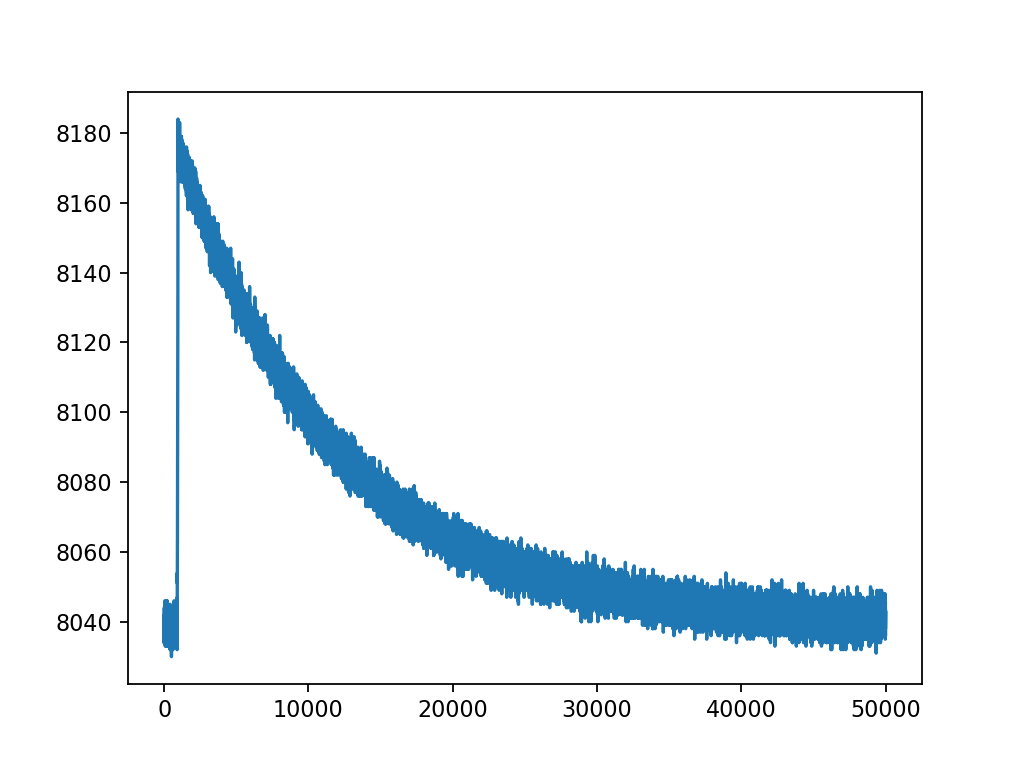

In [170]:
# plot random pulses
# number of random pulses
number_of_pulses = 1
plt.figure()
for i in range(number_of_pulses):
    n = int(np.random.rand()*len(cs))
    plt.plot(cs[n])
#plt.xlim(920,1150)
plt.show()
plt.savefig('figs/example_pulse.png')

### subtract baseline

In [3]:
cs_bkg = subtract_baseline(cs)
co_bkg = subtract_baseline(co)
ba_bkg = subtract_baseline(ba)
# co_cs_bkg = subtract_baseline(co_cs)
# ba_bkg = subtract_baseline(ba)

<IPython.core.display.Javascript object>


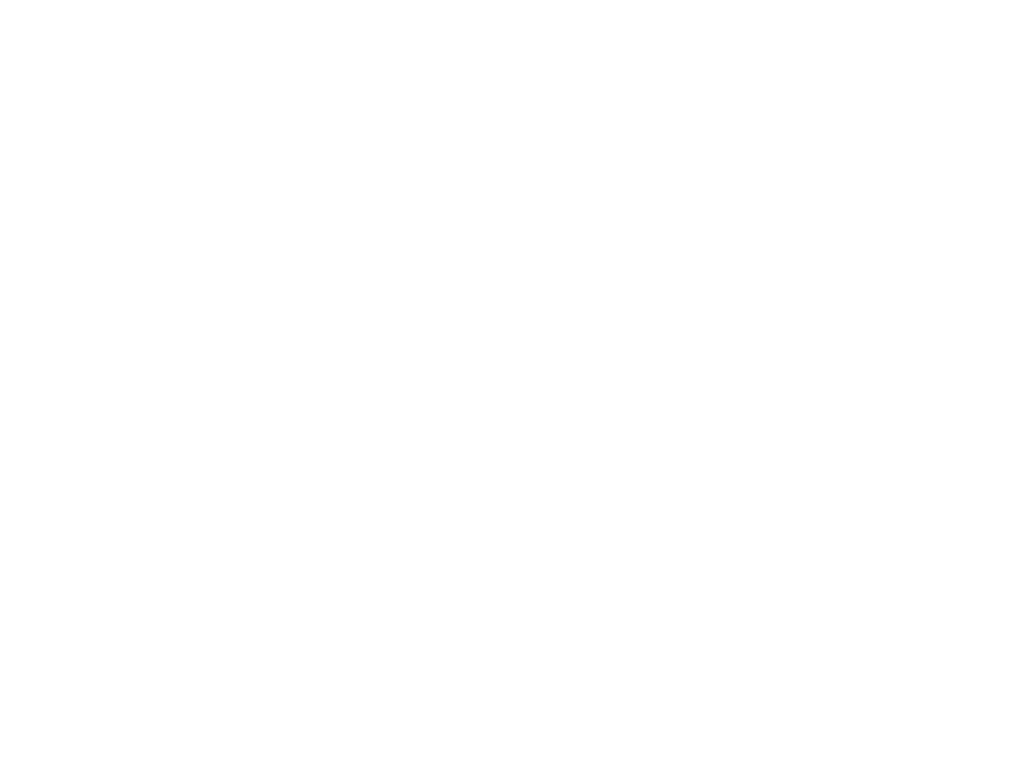

NameError: name 'cs_bkg' is not defined

In [113]:
# plot random pulses
# number of random pulses
number_of_pulses = 100
plt.figure()
for i in range(number_of_pulses):
    n = int(np.random.rand()*len(cs_bkg))
    plt.plot(cs_bkg[n])
#plt.xlim(920,1150)
plt.show()

# apply trapezoidal filter to raw waveform

In [4]:
# first downsample data a reasonable amount
cs_down = cs_bkg[::100]
cs_down.shape

(1521, 50000)

<IPython.core.display.Javascript object>


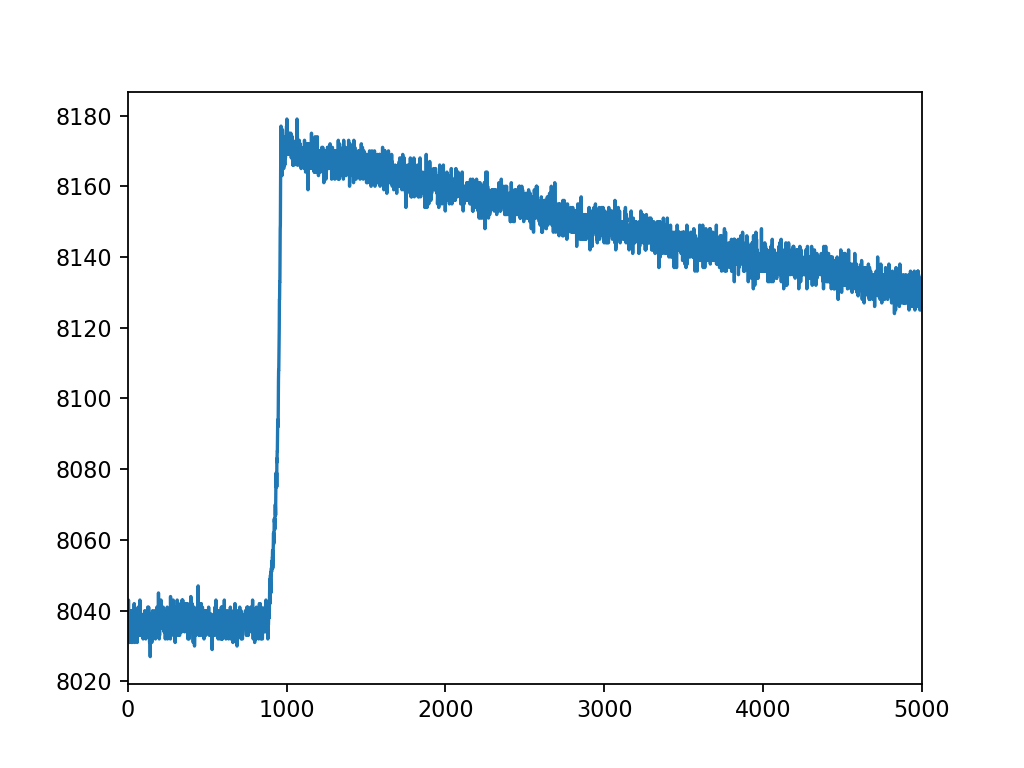

In [119]:
plt.figure()
plt.plot(cs[3])
plt.xlim(0,5000)
plt.show()

## fit tau

In [5]:
tauvals = fit_taus(cs_down)

# we can see we have a pretty large mean and standard deviation
# I expect tau to be around 12,000
# what is causing these high values?
tauvals.mean(), tauvals.std()

mean and variance: 980629861.1072853 1.651341148517282e+20


(980629861.1072853, 12850451931.808788)

<IPython.core.display.Javascript object>


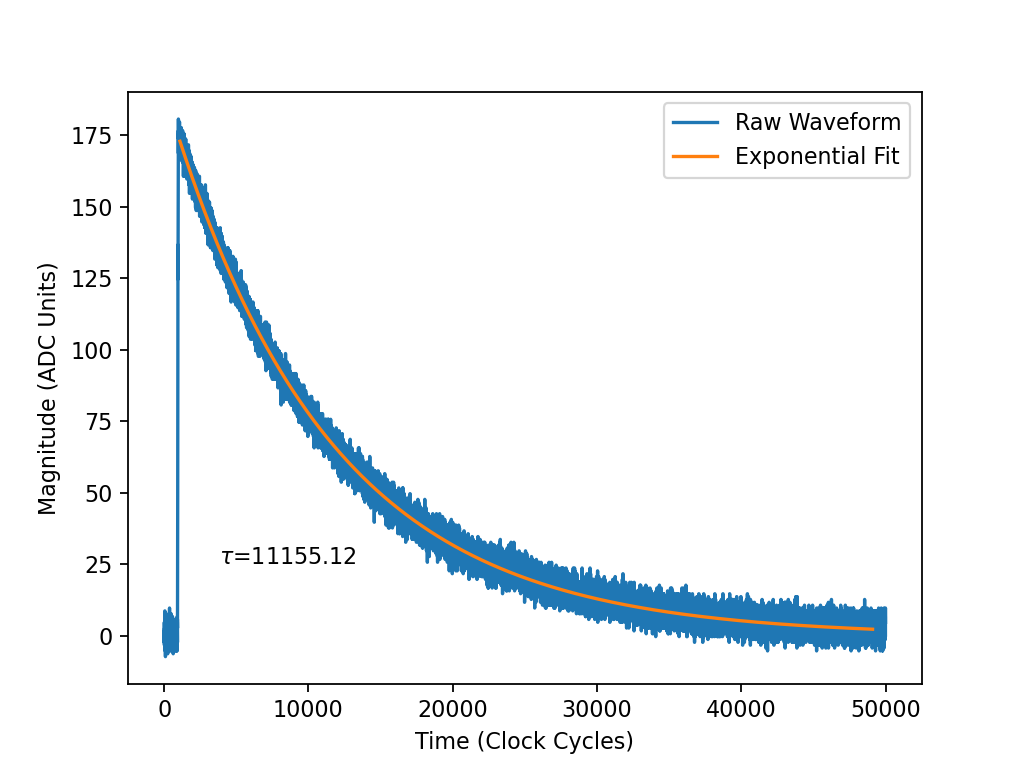

11155.124760950586

In [17]:
#plt.figure()
fit_tau(cs_down[0],show_plot=True)
#plt.show()

In [6]:
# cut more outliers out?
# we want to remove piled up pulses from our tau fit
# piled up pulses typically have large tau, or negative tau
mask = tauvals < 2e4 # less than 15000
mask *= tauvals > 5e3 # at least 1000
good_tau_pulses = cs_down[mask]

tau_fixed = fit_taus(good_tau_pulses)

mean and variance: 10967.425786005182 207115.1253952434


In [179]:
# save as tau for filter
#tau = tau_fixed.mean()
tau = 10967.425786005182
tau = tau * 4 * 10**(-9)

peaking_time = 100 * 4 * 10**(-9)#1.6e-6/2
#peaking_time = 100 * 4 * 10**(-9) * 10
gap_time = peaking_time * 5  #6.4e-6/4

tau, peaking_time, gap_time

(4.3869703144020734e-05, 4.0000000000000003e-07, 2.0000000000000003e-06)

In [4]:
# downsample data so filters can handle it
cs_down = cs[::10]
print(len(cs_down))
ba_bkg_down = ba
print(len(ba_bkg_down))
co_bkg_down = co[::10]
print(len(co_bkg_down))

15206
8822
13895


In [180]:
# Jordanov_filter = JordanovFilter(peaking_time, gap_time, tau)
# Bogovac_filter = BogovacFilter(peaking_time, gap_time, tau)
Cooper_filter = CooperFilter(peaking_time, gap_time, tau)

In [181]:
filtered_cs = Cooper_filter.filter_waveform(cs_down,normalize=True)

#filtered_waves = trap_filter.filter_waveform(cs_bkg,normalize=False)
#filtered_waves = trap_filter.filter_waveform(filtered_cal_pulses,normalize=False)
# filtered_waves = trap_filter.filter_waveform(filtered_cal_pulses_down,normalize=False)

In [184]:
filtered_ba = Cooper_filter.filter_waveform(ba_bkg_down,normalize=True)

In [185]:
filtered_co = Cooper_filter.filter_waveform(co_bkg_down,normalize=True)

In [116]:
filtered_noise = Cooper_filter.filter_waveform(noise,normalize=True)

In [186]:
all_filtered_waveforms = np.concatenate((filtered_cs,filtered_ba,filtered_co),axis=0)

In [213]:
len(all_filtered_waveforms[0])

50000

In [214]:
50000*4**10**-9

50000.00006931472

In [220]:
#250 MHz
50000  /(250* 10**6)

0.0002

<IPython.core.display.Javascript object>


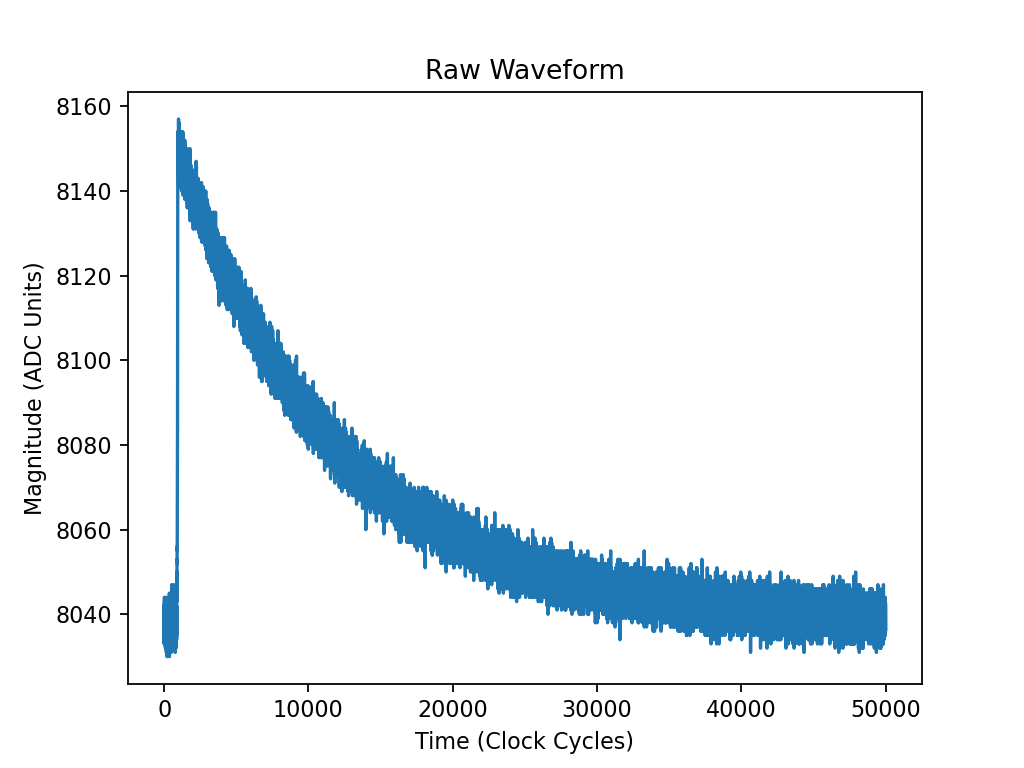

In [223]:
pulse_num = 10
plt.figure()
plt.plot(cs_down[pulse_num])
plt.ylabel('Magnitude (ADC Units)')
plt.xlabel('Time (Clock Cycles)')
plt.title('Raw Waveform')
plt.show()

<IPython.core.display.Javascript object>


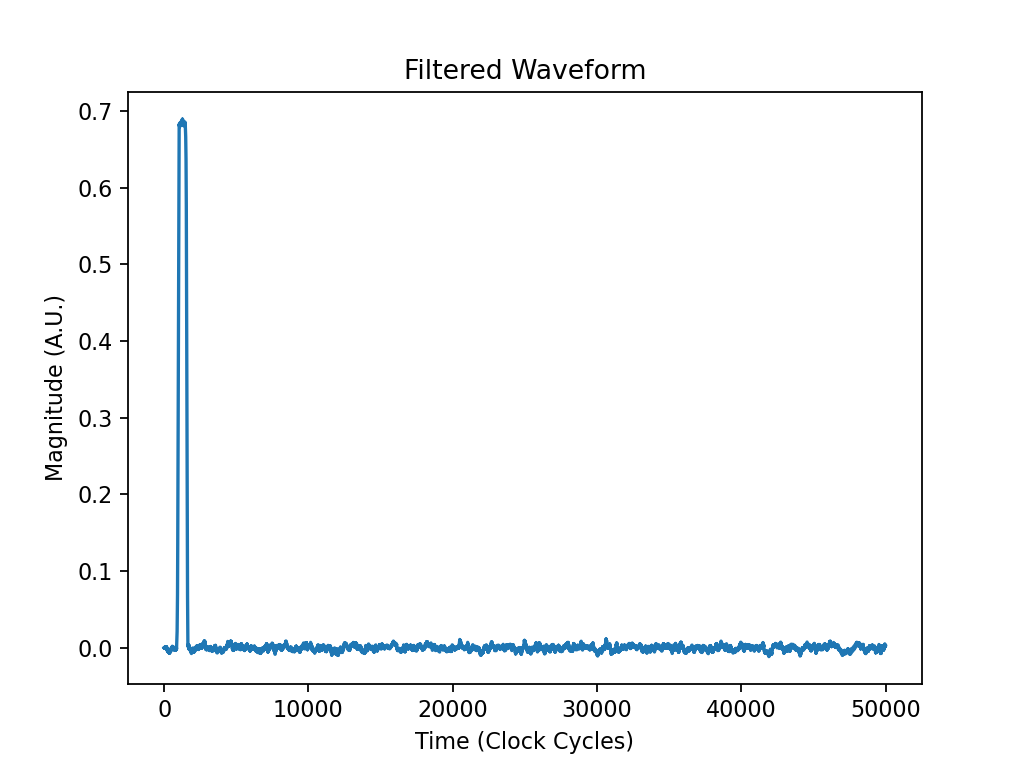

In [224]:
plt.figure()
plt.plot(filtered_cs[pulse_num])
plt.ylabel('Magnitude (A.U.)')
plt.xlabel('Time (Clock Cycles)')
plt.title('Filtered Waveform')
plt.show()

<IPython.core.display.Javascript object>


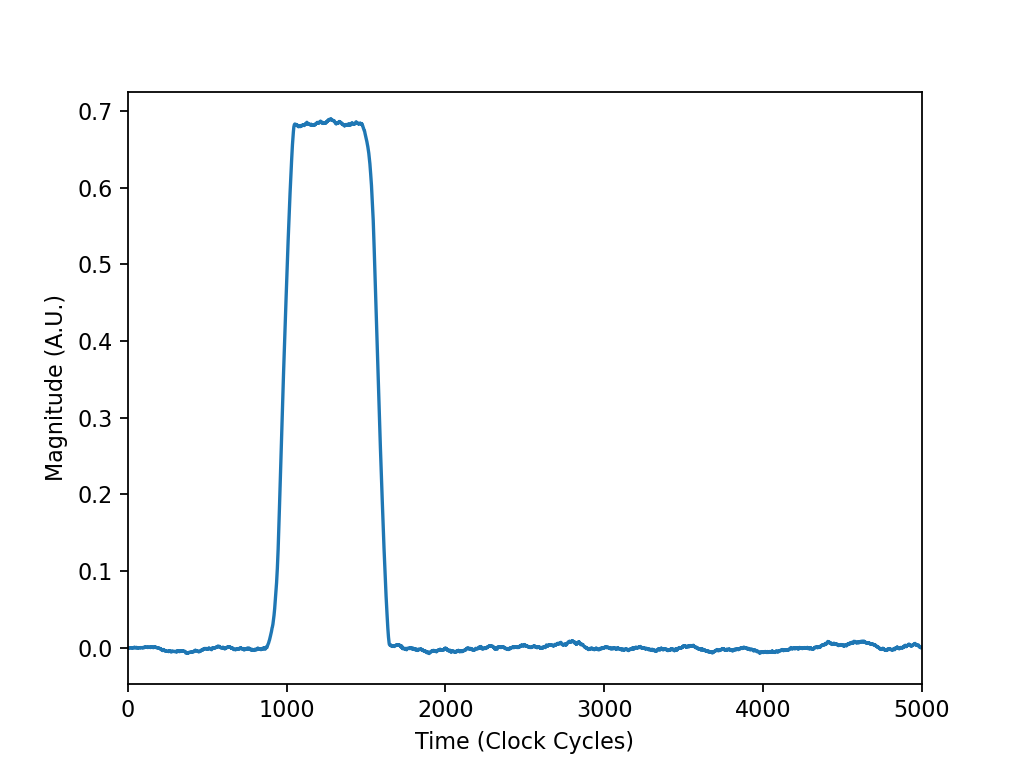

In [225]:
plt.figure()
plt.plot(filtered_cs[pulse_num])
plt.xlim(0,5000)
plt.ylabel('Magnitude (A.U.)')
plt.xlabel('Time (Clock Cycles)')
plt.show()

<IPython.core.display.Javascript object>


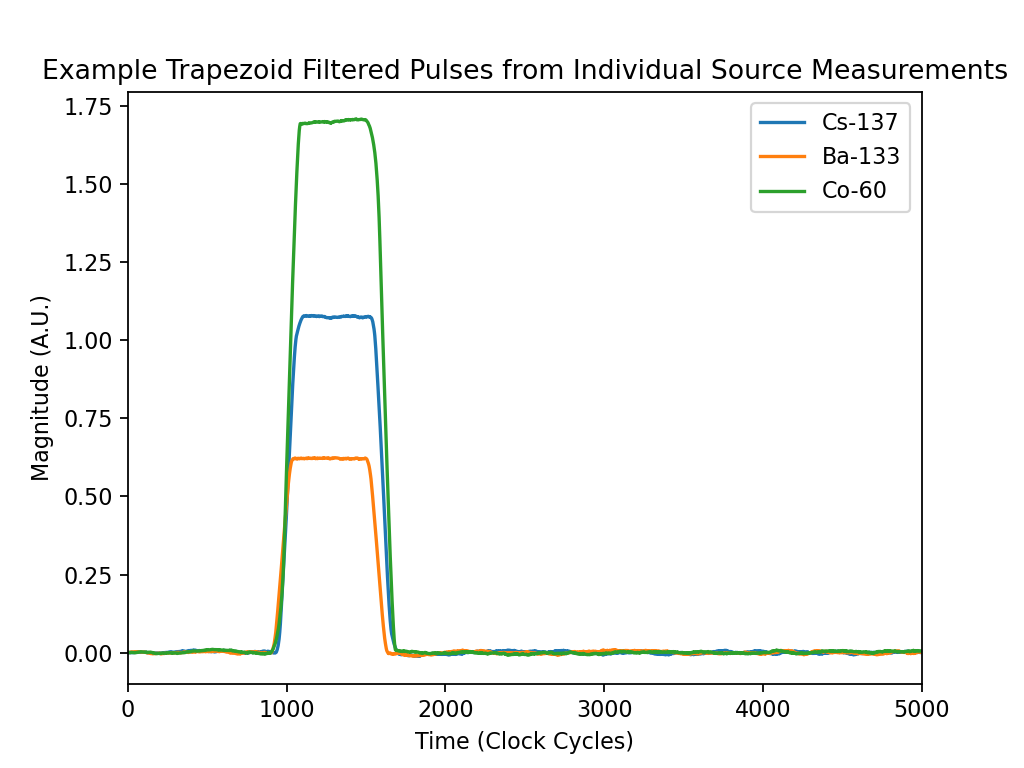

In [232]:
plt.figure()
plt.plot(filtered_cs[12],label='Cs-137')
plt.plot(filtered_ba[6],label='Ba-133')
plt.plot(filtered_co[0],label='Co-60')
plt.xlim(0,5000)
plt.xlabel('Time (Clock Cycles)')
plt.ylabel('Magnitude (A.U.)')
plt.title('Example Trapezoid Filtered Pulses from Individual Source Measurements')
plt.legend()
plt.savefig('all_sources_trapezoids.png')
plt.show()

# Spectral analysis
## Load data into a spectrum

In [233]:
# load filtered waveforms into 'spectrum'
spec = spectrum(all_filtered_waveforms,bins=2000)

<IPython.core.display.Javascript object>


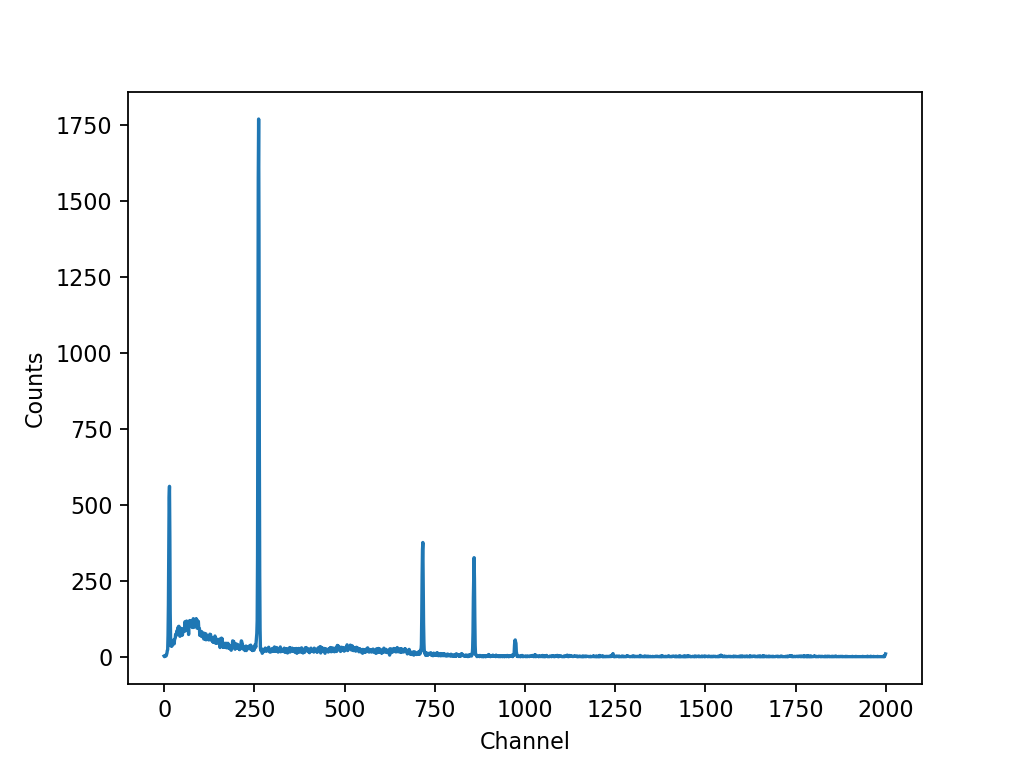

In [234]:
# spectrum histograms trapezoid into a spectrum
spec.plot_spectrum(energy=False,show_calibrated_peaks=False, plot_savefile='figs/channel_spec.png')

## Perform Energy Calibration

Finding Peaks


/Users/kalie/courses/ne204/lab/kalieknecht_lab1/spectrum.py:244: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<IPython.core.display.Javascript object>


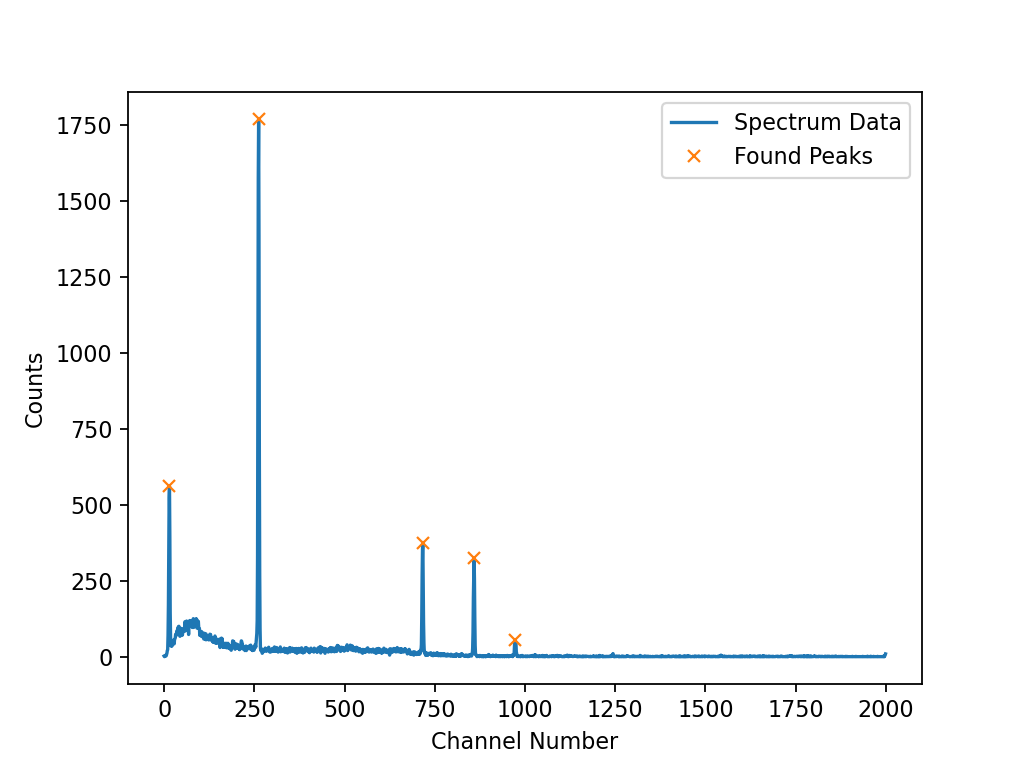

In [267]:
# find gamma peaks
spec.find_gamma_peaks(show_plot=True,prominence=50,width=[0,10],plot_savefile='figs/find_peaks.png')

In [191]:
# relevant gamma energies
energies=[356.0129, 661.7,  1173.228, 1332.492]
compton_edges = np.array([477.,963.,1118.])
# k40 and tl208
background_peaks = np.array([1460.820,1764,2614.511])
possible_pileups = np.array([1173.228+1332.492,662*2,1173.228*2,1332.492*2])

In [268]:
# energies = [356.0129, 661.7,  1173.228, 1332.492, 1460.820]
energies = [383.8485, 661.7,  1173.228, 1332.492, 1460.820]

In [269]:
# provide energies of gamma peaks selected by `find_gamma_peaks`
#spec.find_energy_calibration(energies=[356.0129, 661.7,  1173.228, 1332.492,1460.820],alternative='greater')
spec.find_energy_calibration(energies=energies,alternative='greater')

Finding energy calibration


/Users/kalie/courses/ne204/lab/kalieknecht_lab1/spectrum.py:384: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<IPython.core.display.Javascript object>


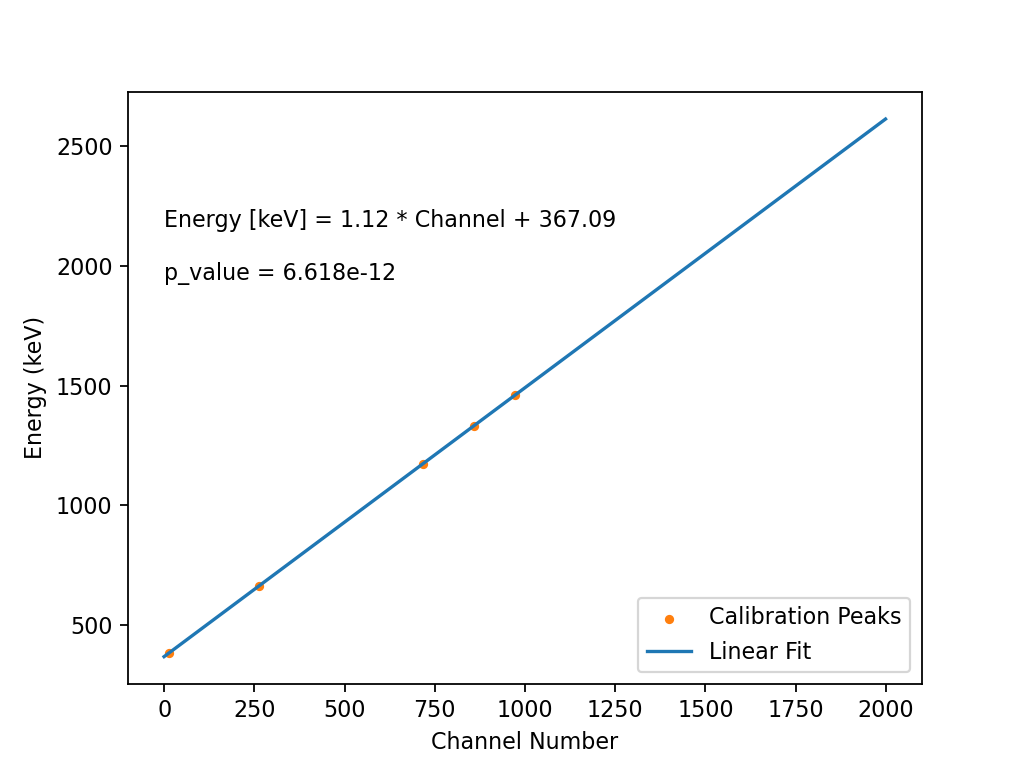

Energy [keV] = 1.12 * Channel + 367.09


In [270]:
# visualize energy calibration
spec.plot_energy_calibration(show_equation=True,plot_savefile='figs/energy_cal.png')

/Users/kalie/courses/ne204/lab/kalieknecht_lab1/spectrum.py:346: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<IPython.core.display.Javascript object>


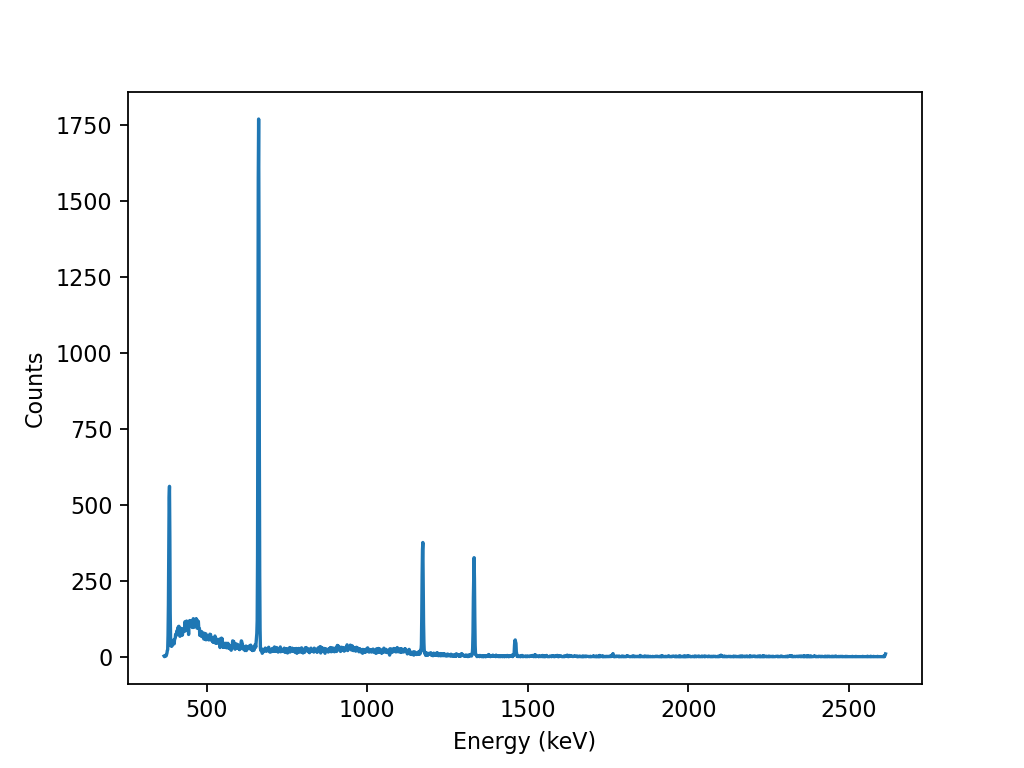

In [271]:
# see spectrum with x-axis as energy
spec.plot_spectrum(show_calibrated_peaks=False,plot_savefile='figs/energy_cal_spectra.png')

In [272]:
fitted_energies = energies
#fitted_energies.append(background_peaks[0])

print(np.isclose(fitted_energies,spec.bin_energies[spec.peaks],atol=5))
fitted_energies - spec.bin_energies[spec.peaks]

[ True  True  True  True  True]


array([-0.10164881,  0.102659  ,  0.17530496, -0.17972861,  0.00341346])

<IPython.core.display.Javascript object>


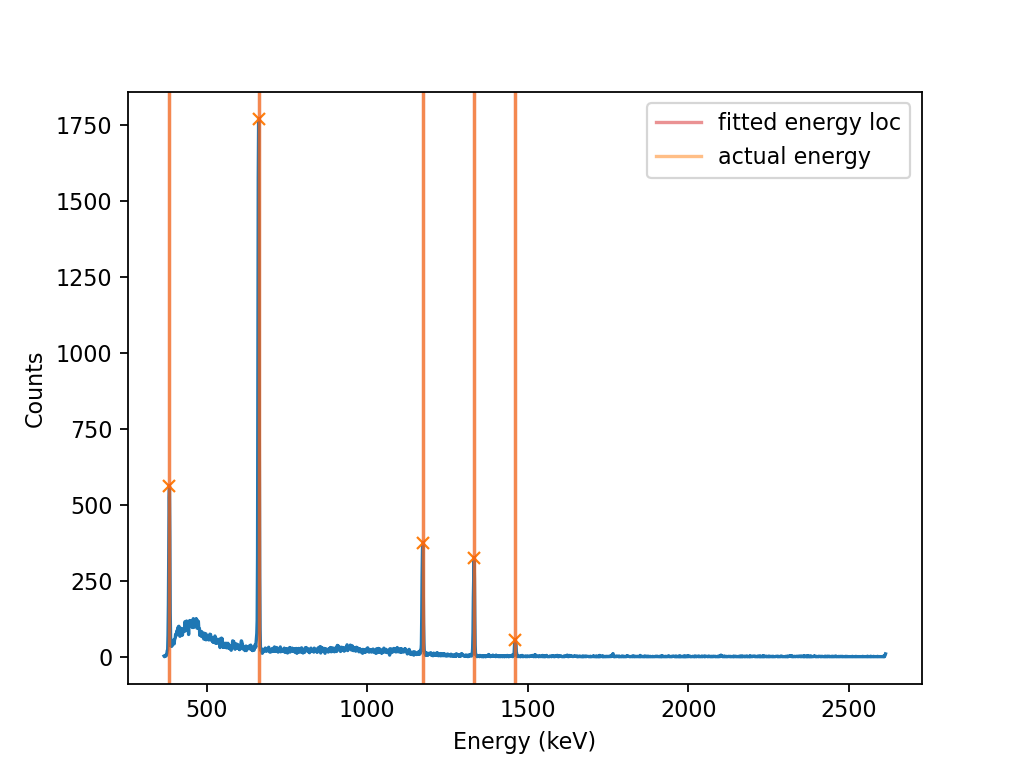

In [197]:
# see spectrum with x-axis as energy
spec.plot_spectrum()
plt.axvline(spec.bin_energies[spec.peaks[0]],c='tab:red',alpha=0.5,label='fitted energy loc')
plt.axvline(fitted_energies[0],c='tab:orange',alpha=0.5,label='actual energy')
for i in range(len(spec.peaks)-1):
    plt.axvline(spec.bin_energies[spec.peaks[i+1]],c='tab:red',alpha=0.5)
    plt.axvline(fitted_energies[i+1],c='tab:orange',alpha=0.5)
plt.legend()

<IPython.core.display.Javascript object>


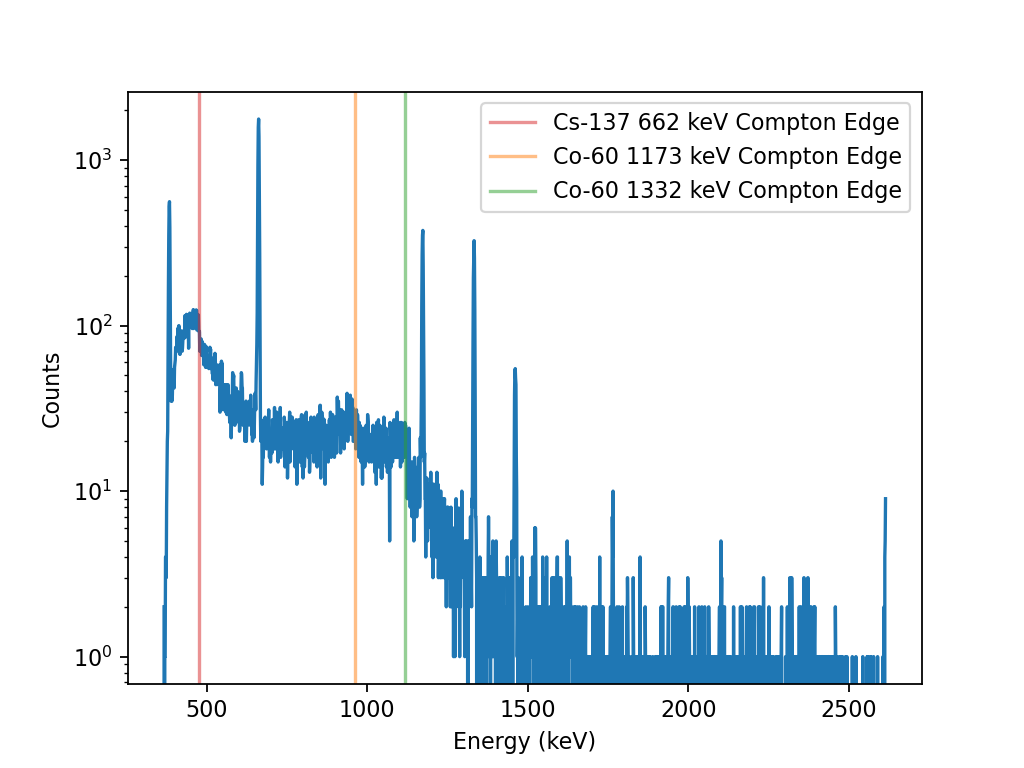

In [273]:
# highlight compton edges
spec.plot_spectrum(semilogy=True,show_calibrated_peaks=False)
plt.axvline(compton_edges[0],c='tab:red',alpha=0.5,label='Cs-137 662 keV Compton Edge')
plt.axvline(compton_edges[1],c='tab:orange',alpha=0.5,label='Co-60 1173 keV Compton Edge')
plt.axvline(compton_edges[2],c='tab:green',alpha=0.5,label='Co-60 1332 keV Compton Edge')
plt.legend()
plt.savefig('figs/spectrum_and_compton_edges.png')
# for i in range(len(compton_edges)):
#     plt.axvline(compton_edges[i],c='tab:red',alpha=0.5,label='Expected Compton Edges')

In [74]:
from spectrum import gaussian
from scipy.optimize import curve_fit

In [78]:
E_wind = 10
centroid = spec.peaks[0]
roi_x = spec.bin_energies[centroid-E_wind:centroid+E_wind]
roi_y = spec.counts[centroid-E_wind:centroid+E_wind]

popt_gauss, pcov_gauss = curve_fit(gaussian, roi_x, roi_y, [spec.counts[centroid],spec.bin_energies[centroid],np.sqrt(spec.counts[centroid])])
                                   

In [82]:
curve_fit?

In [81]:
popt_gauss[2]

1.9201005470103816

In [83]:
gaussian?

In [84]:
popt_gauss

array([539.90903703, 383.72461591,   1.92010055])

In [87]:
spec.counts[spec.peaks[0]]

554

In [85]:
spec.peaks[0]

16

In [86]:
spec.energies[0]

383.8485

## Find Energy Resolution of Peaks

Finding energy resolution calibration


/Users/kalie/courses/ne204/lab/kalieknecht_lab1/spectrum.py:425: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<IPython.core.display.Javascript object>


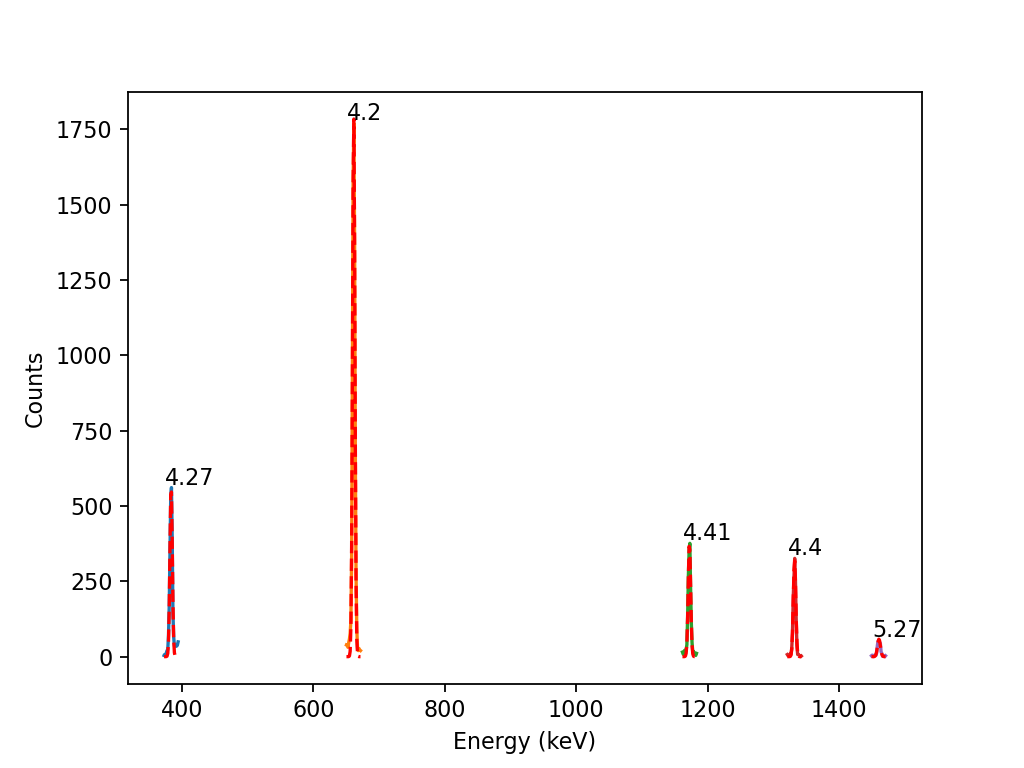

In [274]:
# find energy resolution (FWHM of peaks)
spec.find_fwhm(show_plot=True,show_fwhms=True,E_window=10,plot_savefile='figs/find_fwhm.png')

In [98]:
result = linregress(np.sqrt(spec.energies[0:4]),spec.fwhms[0:4])

<IPython.core.display.Javascript object>


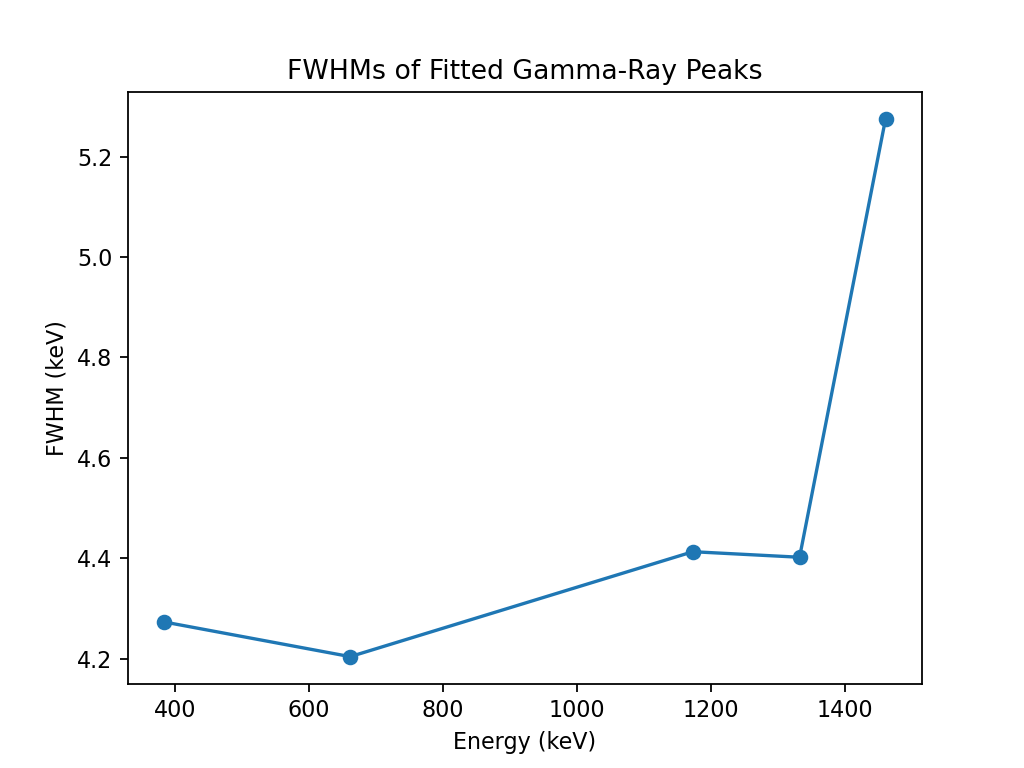

In [275]:
spec.plot_fwhms(plot_savefile='figs/fwhms_vs_energy.png')

In [ ]:
def energy_resolution():
    W = 2.96*10**-3
    Estat = 2.355 * np.sqrt(F * Eg * W)
    e_res = np.sqrt(Estat**2+Enoise**2)

<IPython.core.display.Javascript object>


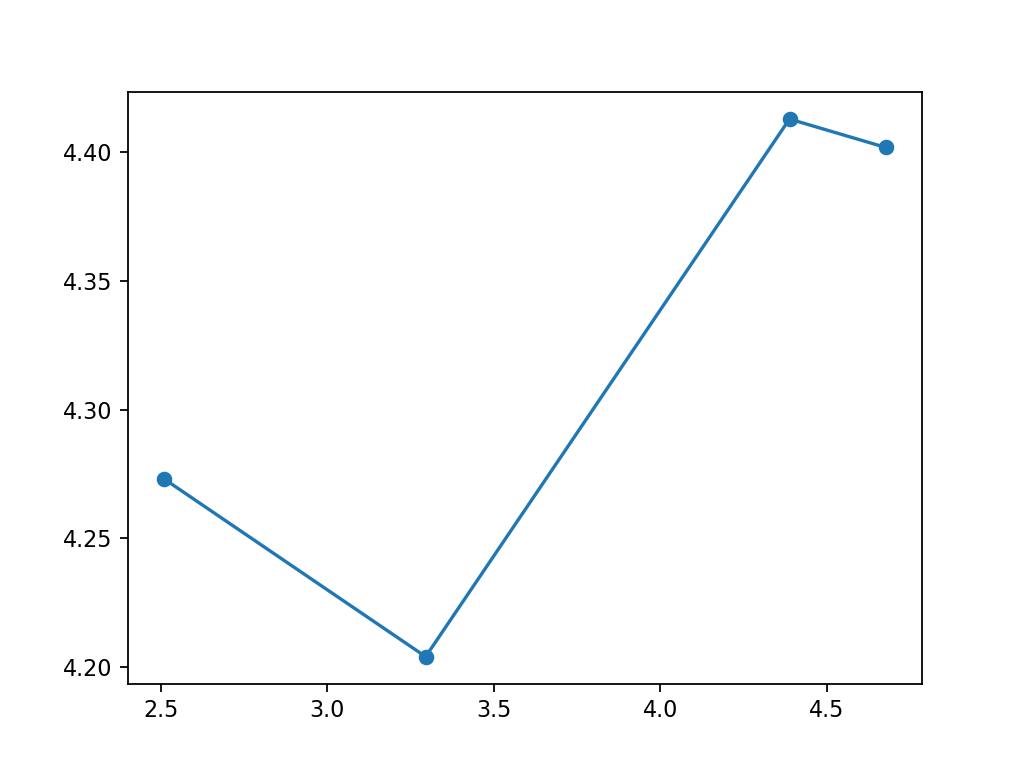

In [201]:
plt.figure()
plt.plot(2.355*np.sqrt(spec.energies[0:4]*2.96*10**-3),spec.fwhms[0:4],marker='o')

<IPython.core.display.Javascript object>


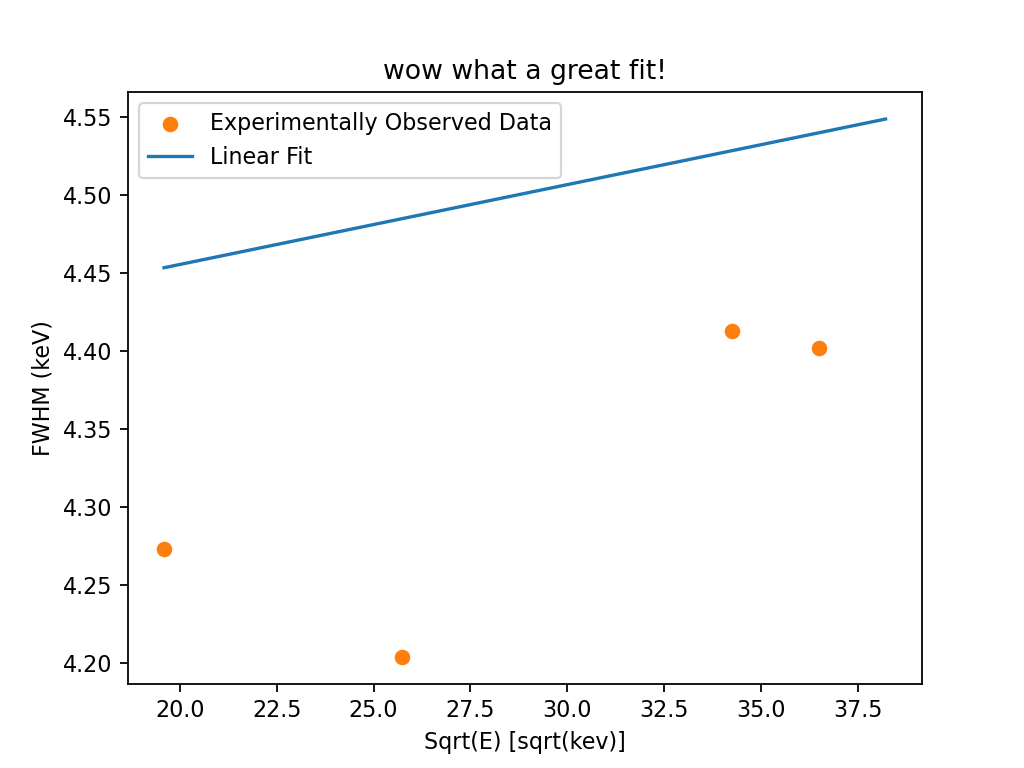

In [202]:
plt.figure()
plt.xlabel('Sqrt(E) [sqrt(kev)]')
plt.text(20,4.8,'FWHM = '+str(round(result.slope,2))+' * sqrt(E) + '+str(round(result.intercept,2)))
plt.scatter(np.sqrt(spec.energies[0:4]),spec.fwhms[0:4],label='Experimentally Observed Data',c='tab:orange')
plt.ylabel('FWHM (keV)')
plt.plot(np.sqrt(spec.energies),result.slope*np.sqrt(spec.energies)+result.intercept,label='Linear Fit')
plt.title("wow what a great fit!")
plt.legend()
plt.show()

In [276]:
spec.find_energy_resolution()

Finding energy resolution calibration


<IPython.core.display.Javascript object>


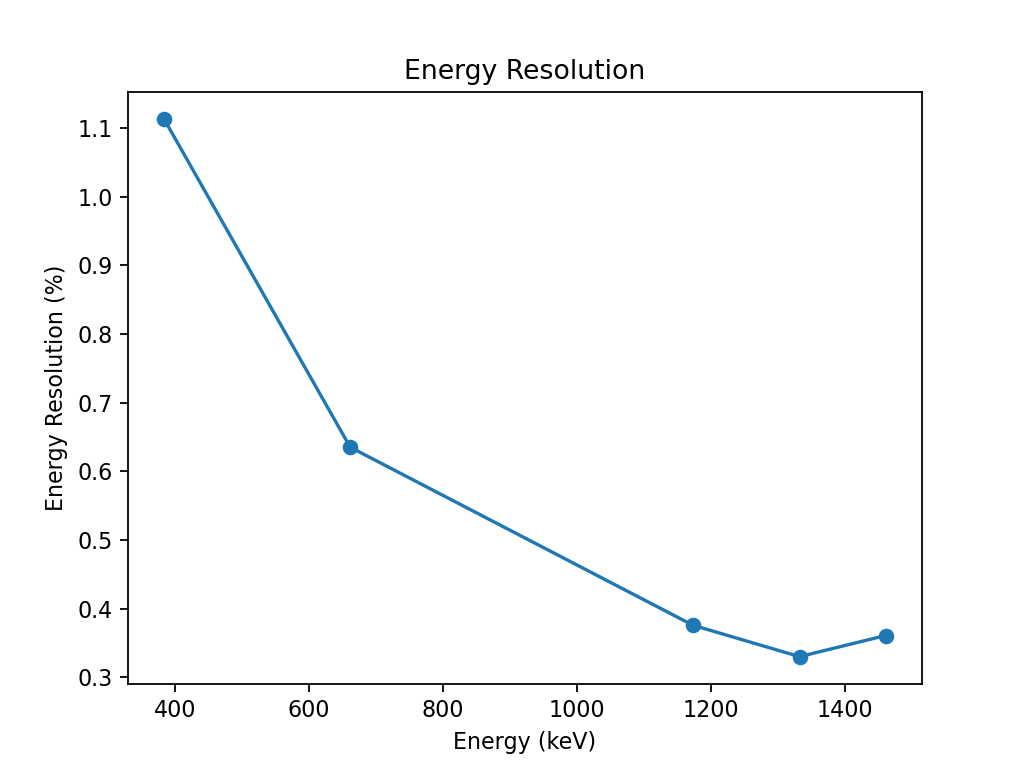

In [278]:
# visualize  FWHMs
spec.plot_energy_resolution(plot_savefile='figs/energy_res_vs_energy.png')
#plt.plot(spec.energies,-np.sqrt(spec.energies))

In [189]:
spec.bin_energies[np.argwhere(spec.channels == 1654)]

AttributeError: 'spectrum' object has no attribute 'bin_energies'

In [142]:
# fwhm in channel = 2.4192834285607936
noise_fwhm_channel = 2.4192834285607936
noise_channel = 1654
# noise_fwhm_energy = noise_fwhm_channel*spec.slope + spec.intercept
noise_fwhm_energy = noise_fwhm_channel * np.mean(spec.bin_energies[noise_channel-10:noise_channel+10]/spec.channels[noise_channel-10:noise_channel+10])
noise_fwhm_energy

3.2574542559794555

In [280]:
spec.find_fano_factor()
print('mean fano factor = ',round(spec.fano_factor.mean(),2),'+/-',round(spec.fano_factor.std(),2))

Finding Fano Factor
mean fano factor =  0.69 +/- 0.29


In [159]:
str(round(spec.fano_factor.mean(),2))

'0.81'

<IPython.core.display.Javascript object>


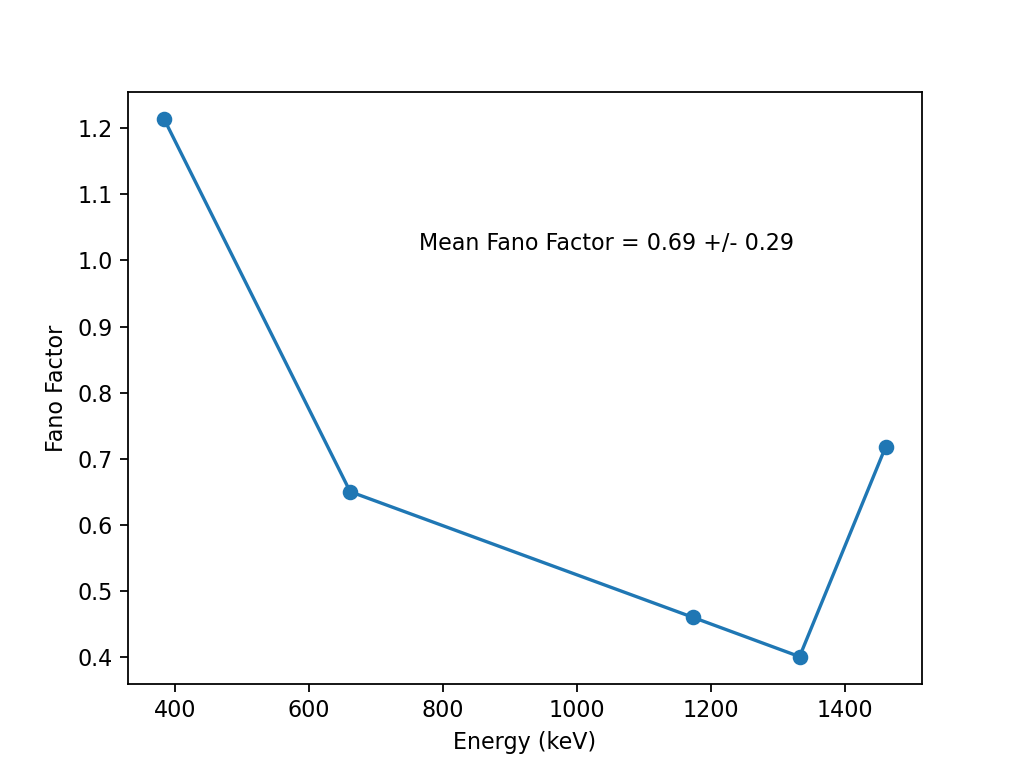

In [282]:
spec.plot_fano_factor(display_mean_fano=True,plot_savefile='figs/fano_wbkg.png')
#plt.text(np.quantile(spec.energies,0.99),np.quantile(spec.fano_factor,0.99),'Fano Factor = '+str(round(spec.fano_factor.mean(),2))+' +/- '+str(round(spec.fano_factor.std(),2))))


In [144]:
spec.fano_factor

array([1.5609361 , 0.79643418, 0.48845123, 0.49147009, 0.69155042])

In [124]:
noise_spec = spectrum(filtered_noise,bins=2000,quantile=0.996)

In [125]:
noise_spec.plot_spectrum(energy=False,show_calibrated_peaks=False)

<IPython.core.display.Javascript object>

In [106]:
obs_var = spec.fwhms**2 / 2.355
pois_var = (np.sqrt(spec.peak_counts))

fano = obs_var/pois_var

In [107]:
fano

array([0.17150017, 0.09412129, 0.20574317, 0.24533531, 0.66014676])

In [30]:
spec.find_energy_resolution()

Finding energy resolution calibration


In [20]:
spec.fwhms

array([4.62950841, 4.49339786, 4.58074713, 4.73192294])

In [114]:
spec.find_fano_factor()

Finding Fano Factor


In [115]:
spec.fano_factor

array([0.94288724, 0.30366802, 0.15717461, 0.21281151])

In [90]:
spec.fwhms**2 - noise_fwhm**2

array([-71.18898182, -73.40095261, -73.67240296, -72.04443819])

# remove background peak for better looking performance

In [283]:
spec.peaks = np.delete(spec.peaks,4)
spec.energies = np.delete(spec.energies,4)

Finding energy resolution calibration


<IPython.core.display.Javascript object>


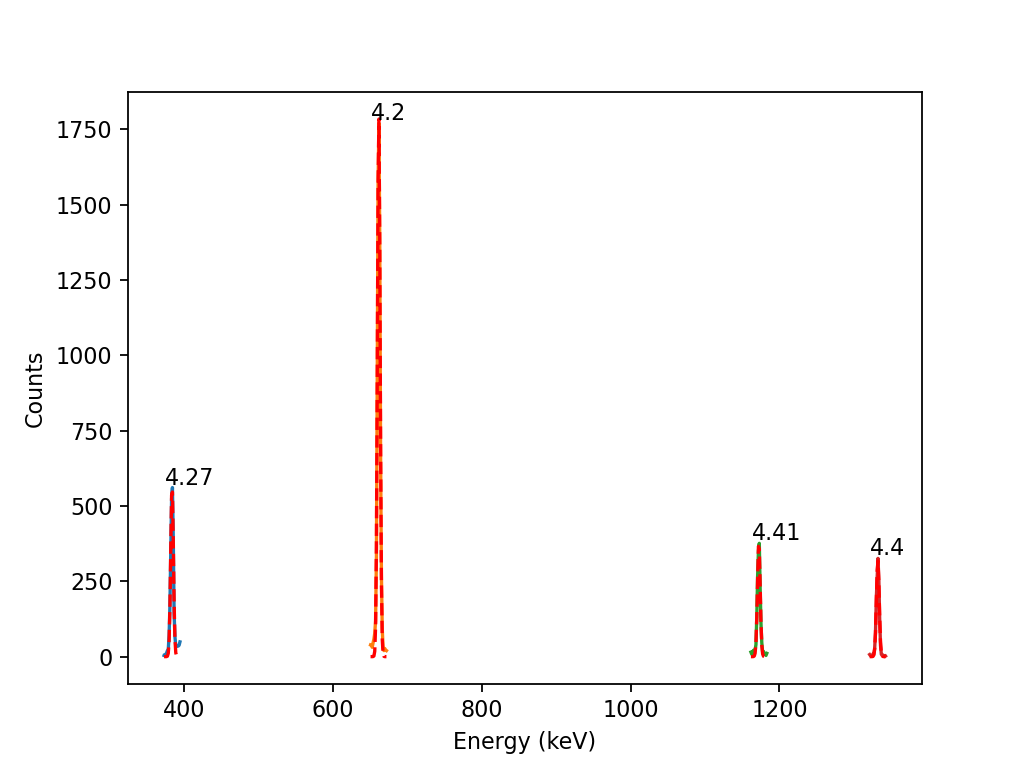

In [284]:

# find energy resolution (FWHM of peaks)
spec.find_fwhm(show_plot=True,show_fwhms=True,E_window=10,plot_savefile='figs/find_fwhm_nobkg.png')

<IPython.core.display.Javascript object>


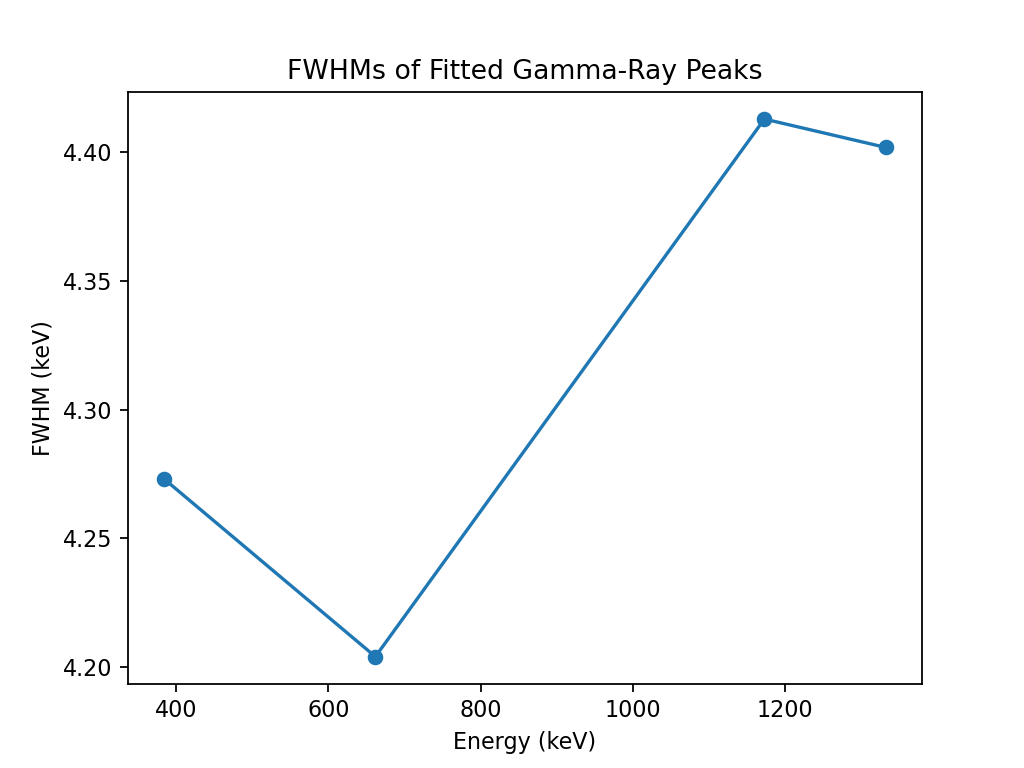

In [285]:
spec.plot_fwhms(plot_savefile='figs/fwhms_vs_energy_nobkg.png')

In [286]:
spec.find_energy_resolution()

Finding energy resolution calibration


<IPython.core.display.Javascript object>


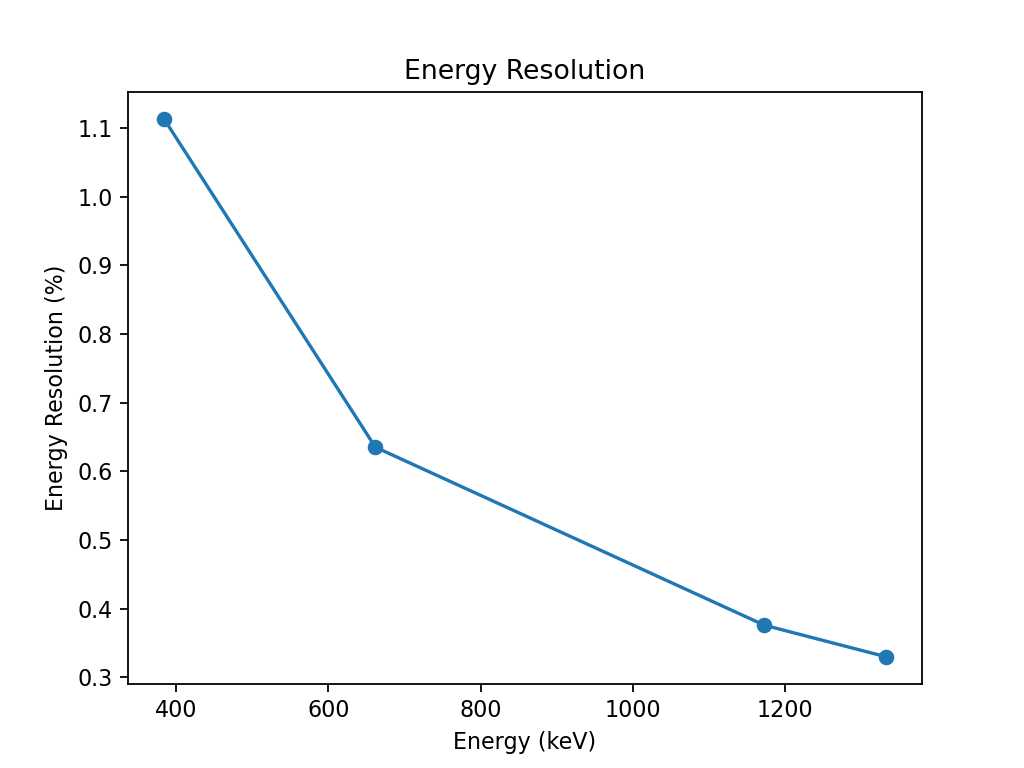

In [288]:
spec.plot_energy_resolution(plot_savefile='figs/eres_nobkg.png')

In [289]:
spec.find_fano_factor()

Finding Fano Factor


<IPython.core.display.Javascript object>


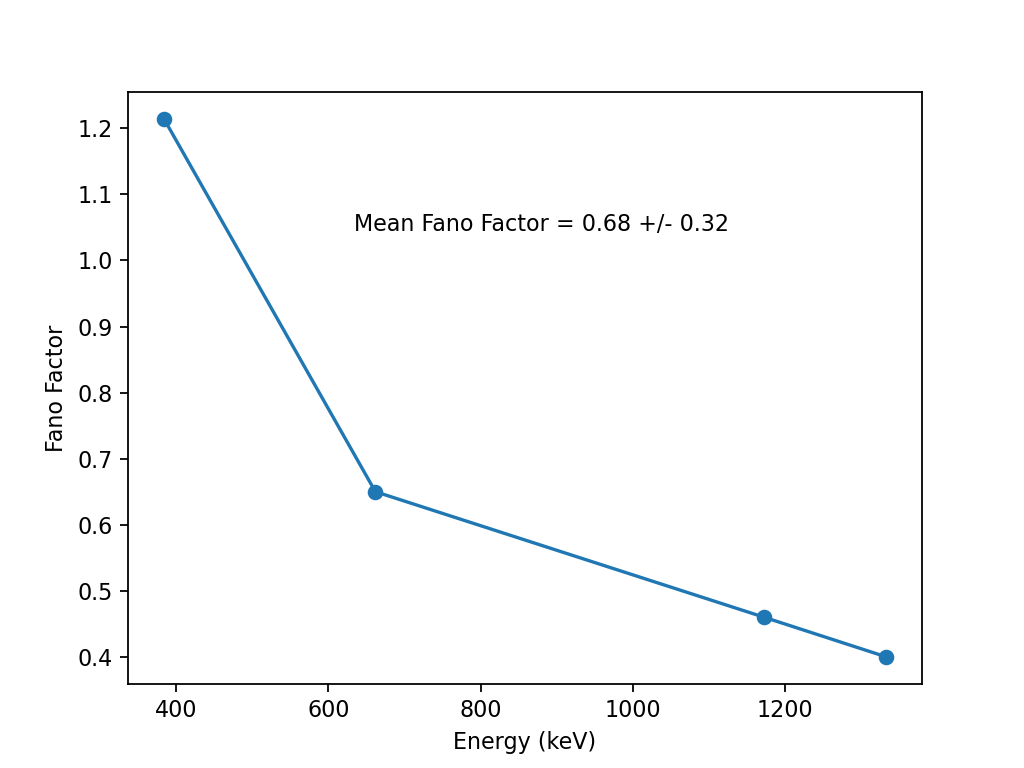

In [292]:
spec.plot_fano_factor(plot_savefile='fano_no_bkg.png',display_mean_fano=True)

# find noise contribution

In [25]:
noise_trapezoids = filtered_noise.max(axis=1)

In [26]:
all_trapezoids = np.append(noise_trapezoids,spec.trapezoid_heights)

In [75]:
noise_spectrum = spectrum(np.array([0,1]),trap_heights=all_trapezoids,bins=2000,quantile=0.9926)

<IPython.core.display.Javascript object>


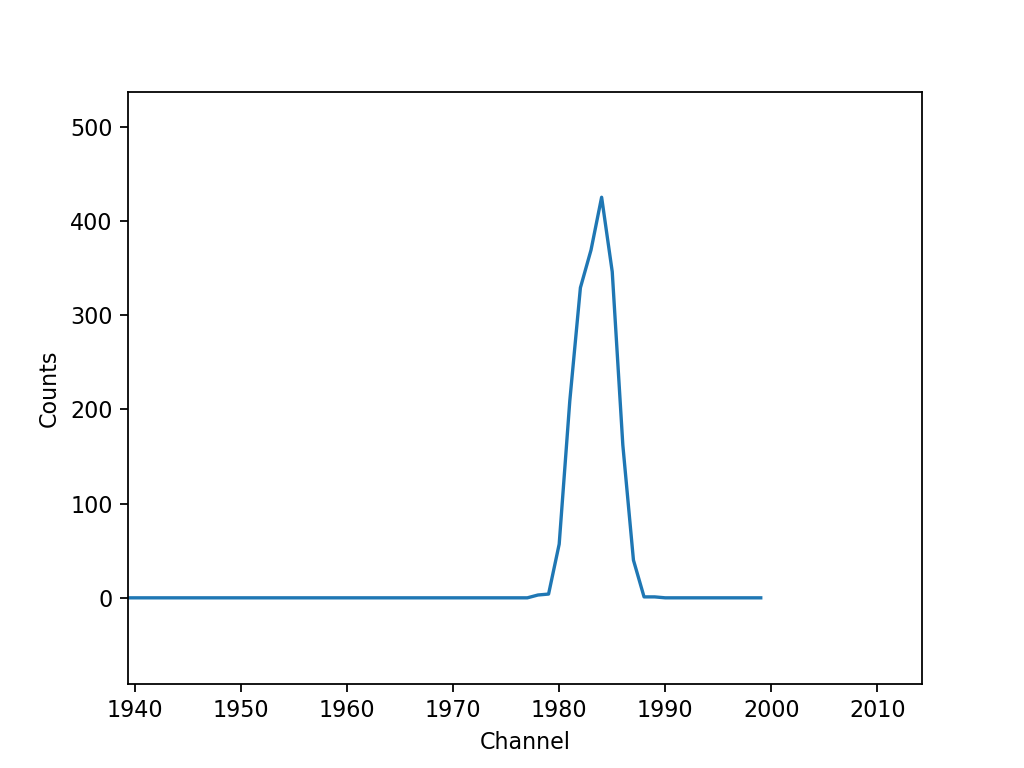

In [76]:
noise_spectrum.plot_spectrum(energy=False,show_calibrated_peaks=False)

Finding Peaks


<IPython.core.display.Javascript object>


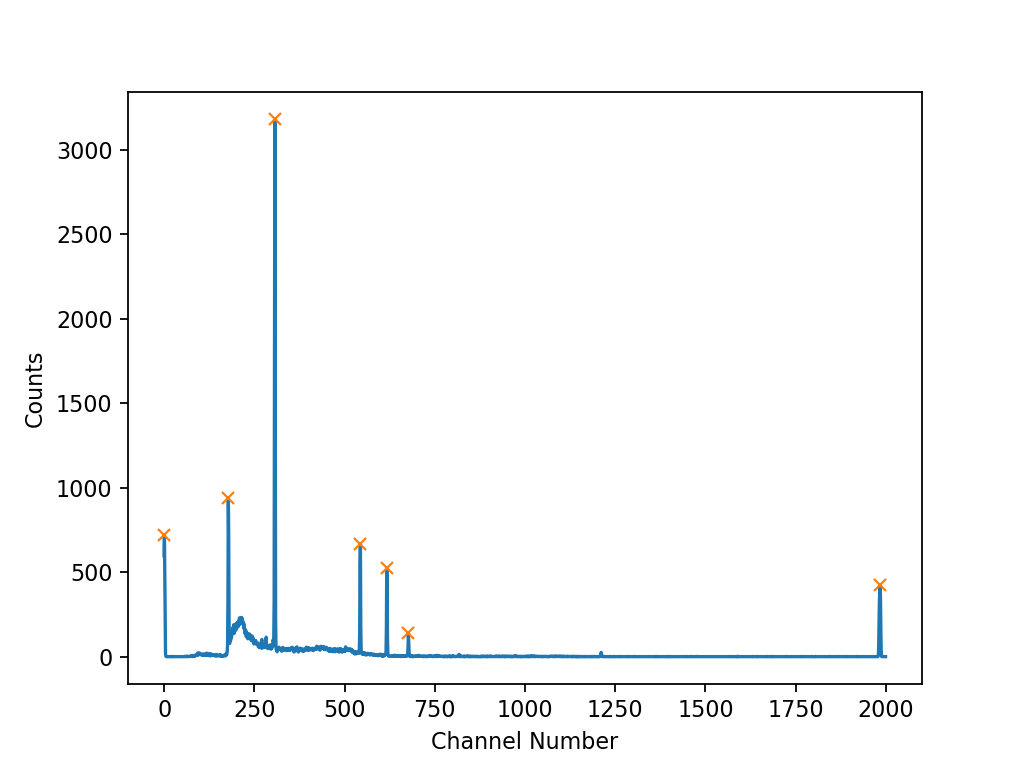

In [77]:
noise_spectrum.find_gamma_peaks(show_plot=True)

In [78]:
old_peaks = noise_spectrum.peaks

In [79]:
noise_spectrum.peaks = np.delete(noise_spectrum.peaks,5)
noise_spectrum.peaks = np.delete(noise_spectrum.peaks,5)
noise_spectrum.peaks = np.delete(noise_spectrum.peaks,0)

In [80]:
noise_spectrum.find_energy_calibration(energies)

Finding energy calibration


<IPython.core.display.Javascript object>


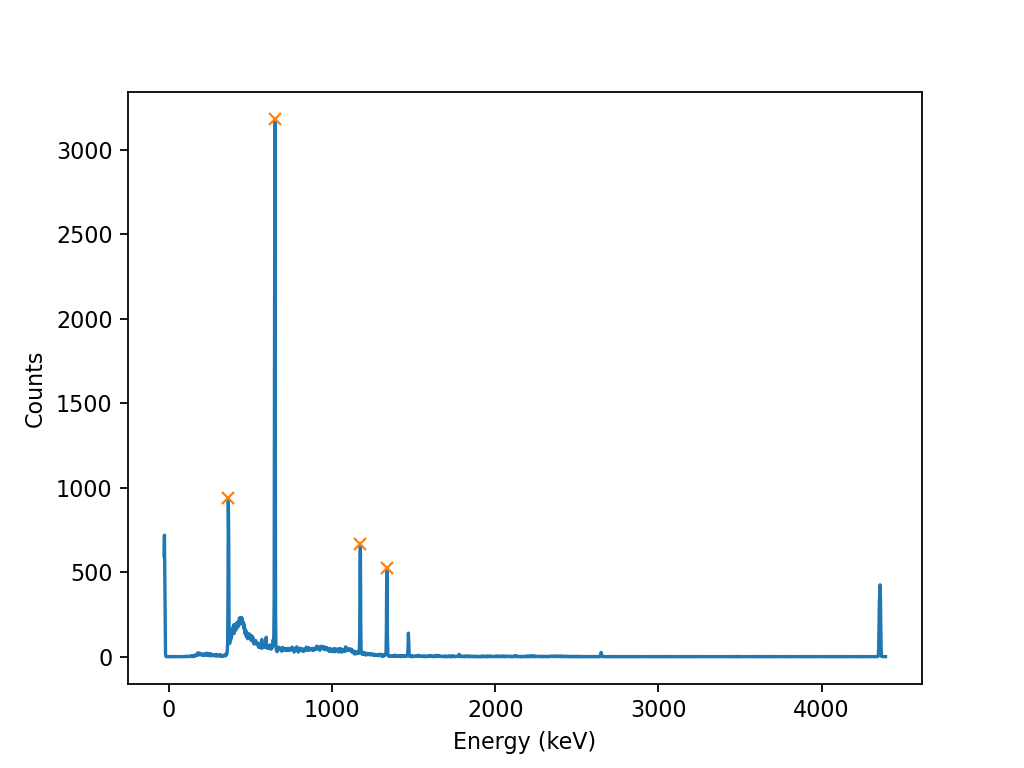

In [81]:
noise_spectrum.plot_spectrum()

<IPython.core.display.Javascript object>


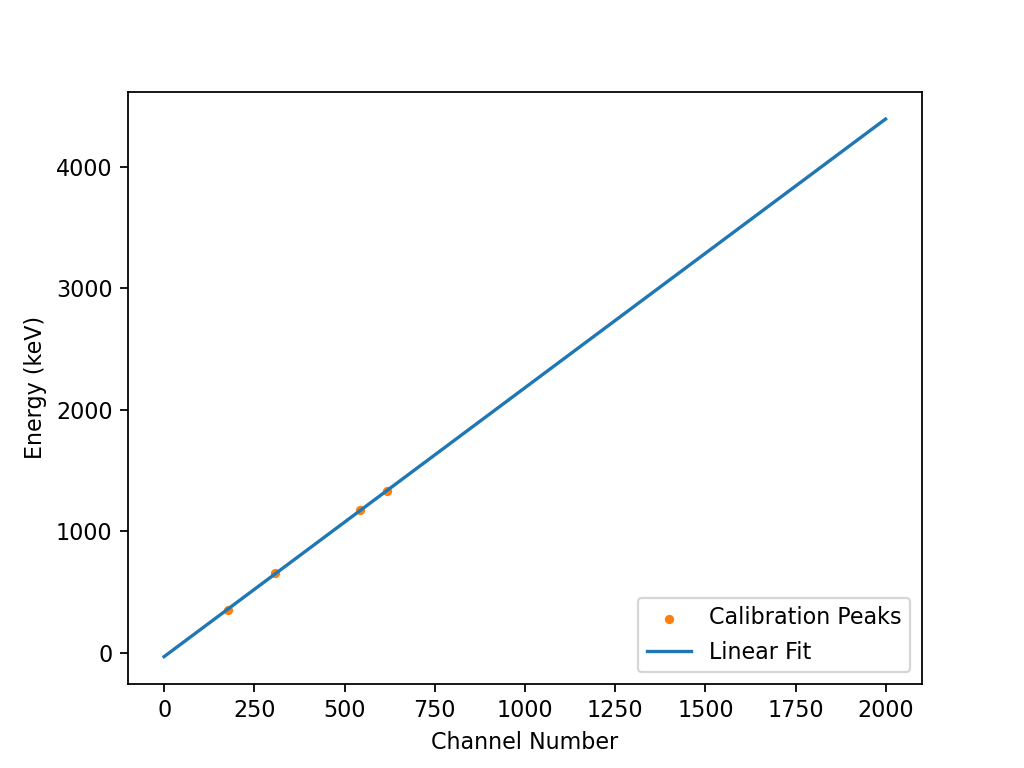

In [82]:
noise_spectrum.plot_energy_calibration()

In [83]:
# add pulser peak back in to find fwhm
noise_spectrum.peaks = np.append(noise_spectrum.peaks,old_peaks[-1])

Finding energy resolution calibration


<IPython.core.display.Javascript object>


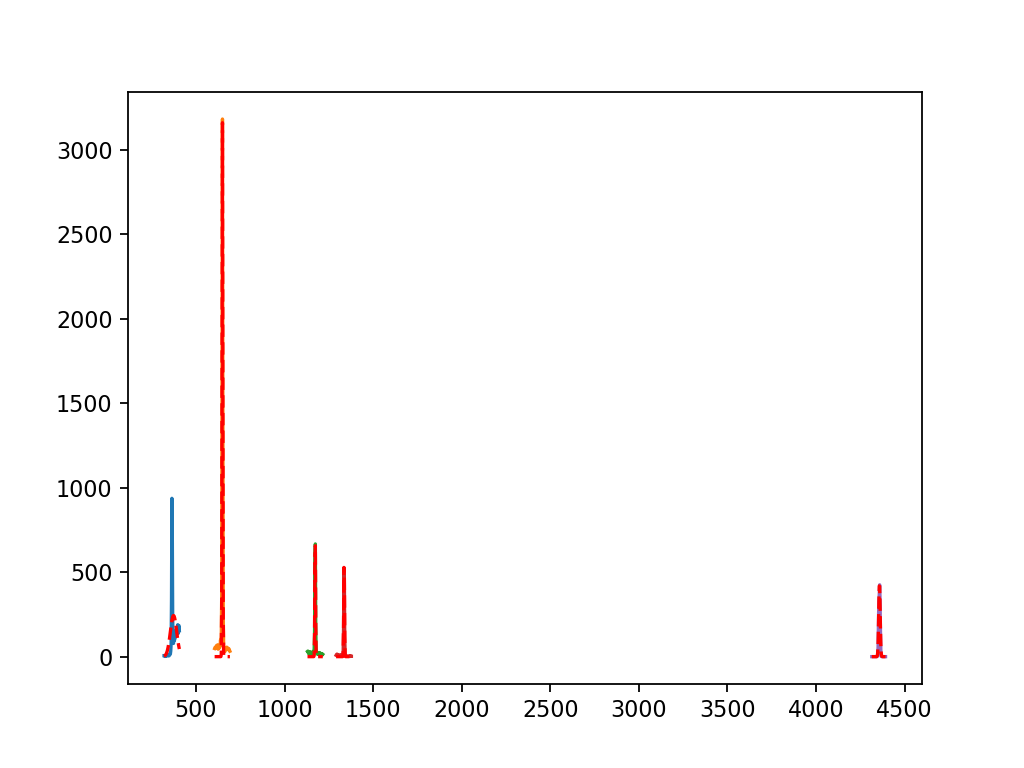

In [84]:
noise_spectrum.find_energy_resolution(show_plot=True)

In [86]:
noise_fwhm = noise_spectrum.fwhms[-1]

In [102]:
noise_spectrum_new = spectrum(filtered_noise,bins=2000,quantile=0.999)


<IPython.core.display.Javascript object>


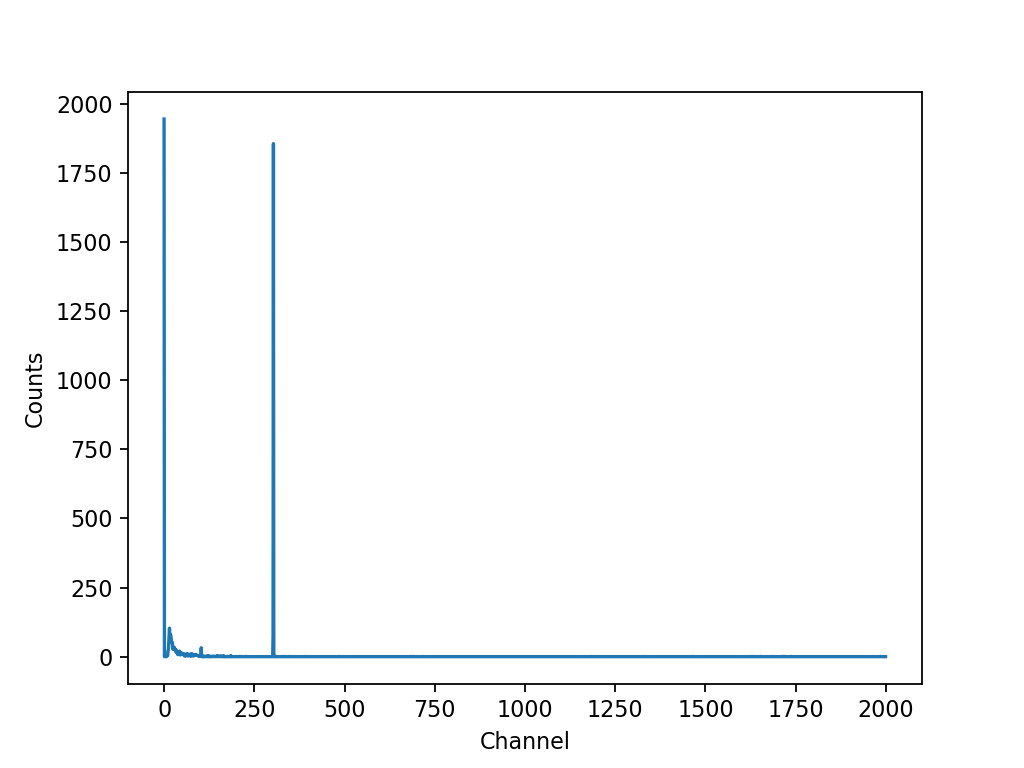

In [104]:
noise_spectrum_new.plot_spectrum(energy=False,show_calibrated_peaks=False)

Finding Peaks


<IPython.core.display.Javascript object>


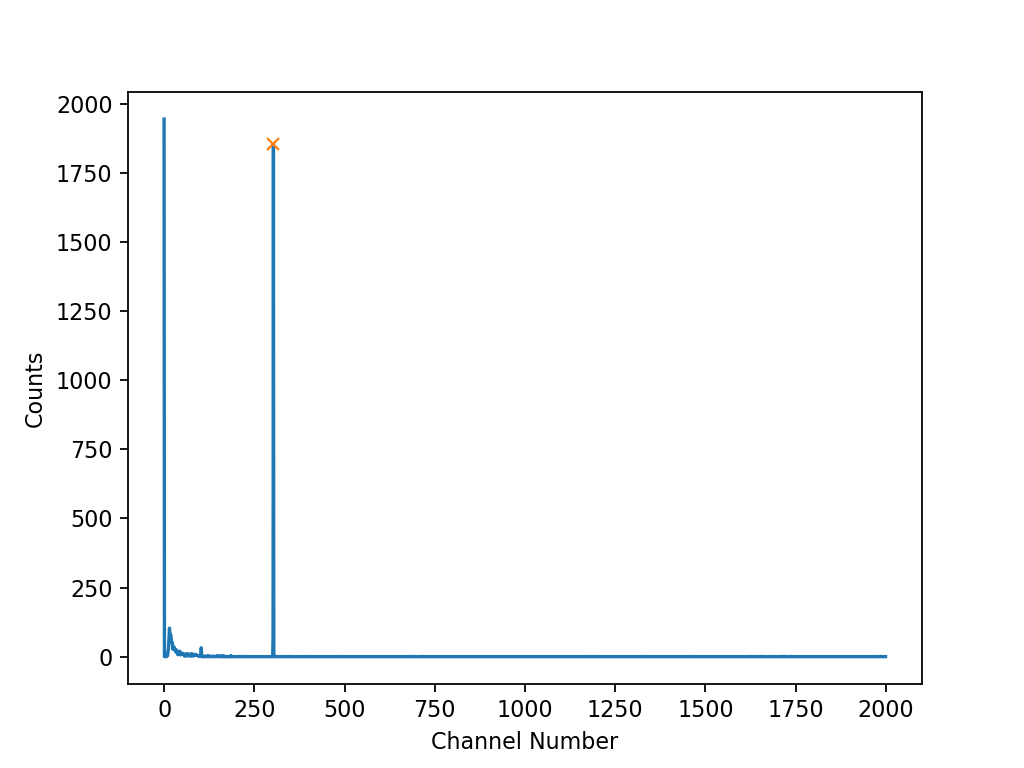

In [107]:
noise_spectrum_new.find_gamma_peaks(show_plot=True)

In [108]:
noise_spectrum_new.peaks

array([303])

In [87]:
noise_fwhm

9.628062296356013

In [197]:
noise_ave_baseline=filtered_noise[:,3000:].mean(axis=1)

In [ ]:
filtered_noise_compatible = np.insert(filtered_noise,-1,noise_ave_baseline)

In [203]:
filtered_noise.shape

(5634, 5000)

In [205]:
noise_ave_baseline.shape

(5634,)

In [200]:
filtered_noise_compatible.shape

(28175634,)

In [186]:
pulser_spec = spectrum(signal_noise_waveforms)

AxisError: axis 1 is out of bounds for array of dimension 1

In [185]:
pulser_spec

NameError: name 'pulser_spec' is not defined

In [173]:
spec.trapezoid_heights

array([1.07437984, 0.68791145, 0.73515803, ..., 1.06790756, 0.74572354,
       1.79829604])

In [174]:
noise_traps = filtered_noise.max(axis=1)

In [177]:
np.append(noise_traps,spec.trapezoid_heights).shape

(43557,)

In [117]:
spec.fwhms

array([4.63795232, 4.39302071, 4.36201566, 4.54479322])

# individual isotope spectrums

In [145]:
# use full spectrum bin limits for consisten plotting

bin_limits = [spec.bin_edges.min(),spec.bin_edges.max()]

In [148]:
cs_spec = spectrum(filtered_cs,bins=2000,bin_limits=bin_limits)
#cs_spec.run_full_pipeline(energies=[661.7],prominence=70)

Finding Peaks


<IPython.core.display.Javascript object>


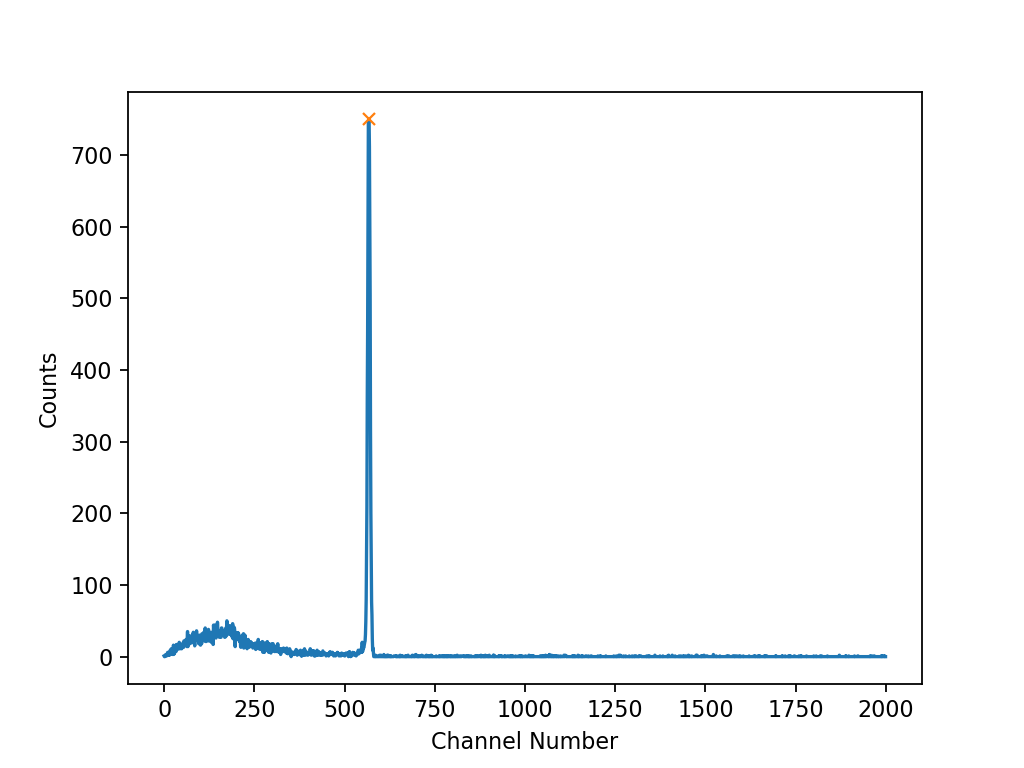

In [149]:
cs_spec.find_gamma_peaks(show_plot=True)

In [151]:
ba_spec = spectrum(filtered_ba,bins=2000,bin_limits=bin_limits)
#ba_spec.run_full_pipeline(energies=[356.0129],prominence=70)

<IPython.core.display.Javascript object>


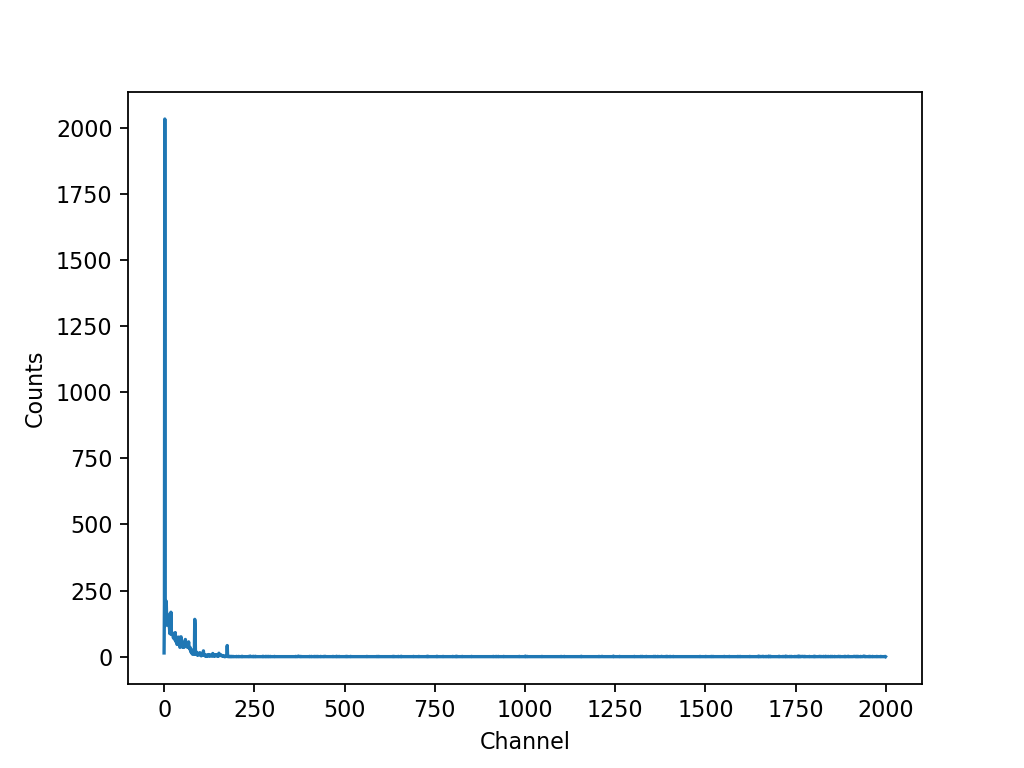

In [152]:
ba_spec.plot_spectrum(energy=False,show_calibrated_peaks=False)

Finding Peaks


<IPython.core.display.Javascript object>


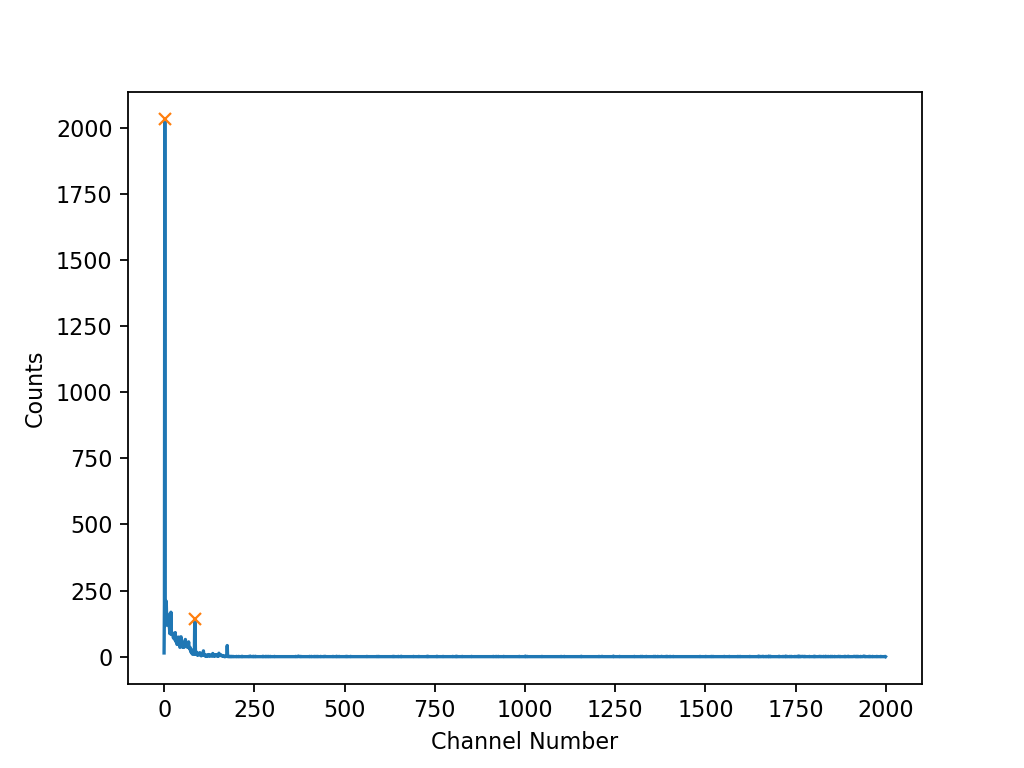

In [153]:
ba_spec.find_gamma_peaks(show_plot=True,prominence=100)

In [154]:
co_spec = spectrum(filtered_co,bins=2000,bin_limits=bin_limits)
#co_spec.run_full_pipeline(energies=[1173.228, 1332.492],prominence=70)

<IPython.core.display.Javascript object>


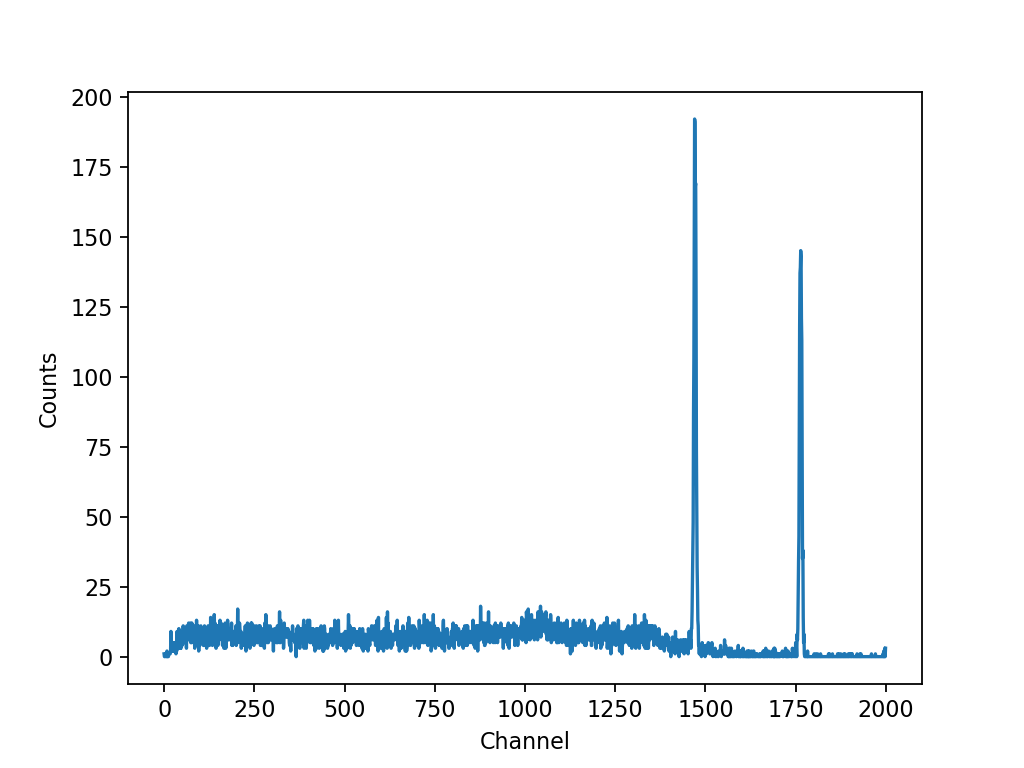

In [155]:
co_spec.plot_spectrum(energy=False,show_calibrated_peaks=False)

In [140]:
co_spec.bin_edges.max()

2.3734848030521625

In [141]:
bin_max

4.244040044484098

In [156]:
np.histogram?